#1. Introduction

ResumeMatcher is an AI-powered tool that helps job seekers optimize their resumes for Applicant Tracking Systems (ATS). This notebook implements a complete pipeline for analyzing and improving resumes based on specific job descriptions.

What is an ATS? An Applicant Tracking System (ATS) is software used by employers to collect, organize, and filter job applications. These systems use algorithms to scan resumes for relevant keywords and qualifications before they reach human recruiters.

Why is ATS optimization important? Studies show that over 75% of resumes are rejected by ATS before a human ever sees them. Optimizing your resume for these systems significantly increases your chances of getting an interview.

This notebook will walk you through the complete process of:

Parsing resume documents (PDF/DOCX)
Analyzing job descriptions to extract key requirements
Extracting and comparing keywords
Calculating similarity scores
Providing targeted recommendations for resume improvement

#2. Setup and Dependencies

In [ ]:
# Install all necessary libraries
!pip install PyPDF2 pdfplumber docx2txt nltk spacy scikit-learn sentence-transformers matplotlib seaborn plotly textblob pandas numpy
!pip install nltk scikit-learn
# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download spaCy English model
!python -m spacy download en_core_web_sm

print("✅ All libraries installed and setup complete!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ All libraries installed and setup complete!


In [ ]:
# Standard libraries
import os
import json
import re
import string
import uuid
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Data processing & analysis
import numpy as np
import pandas as pd
from collections import Counter

# NLP libraries
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob

# PDF/Document parsing
import PyPDF2
import docx2txt
import pdfplumber

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Vector embeddings
from sentence_transformers import SentenceTransformer

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Create directories for data
os.makedirs('data/resumes', exist_ok=True)
os.makedirs('data/jobs', exist_ok=True)
os.makedirs('output', exist_ok=True)

print("Setup complete! All libraries imported successfully.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Setup complete! All libraries imported successfully.


#3. Resume Parsing Module
Let's start by building our resume parsing module. This module will handle:

Extracting text from PDF and DOCX files
Cleaning and preprocessing the text
Identifying resume sections (Education, Experience, Skills, etc.)
Structuring the extracted data

In [ ]:
class ResumeParser:
    """
    A class for parsing resume documents in PDF or DOCX formats, extracting and structuring the content.
    """

    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.section_headers = {
            'education': ['education', 'academic background', 'academic history', 'qualifications', 'degrees'],
            'experience': ['experience', 'work experience', 'employment history', 'work history', 'professional experience'],
            'skills': ['skills', 'technical skills', 'competencies', 'core competencies', 'expertise'],
            'projects': ['projects', 'personal projects', 'academic projects', 'professional projects'],
            'certifications': ['certifications', 'certificates', 'licenses', 'accreditations'],
            'summary': ['summary', 'professional summary', 'profile', 'professional profile', 'about me']
        }

    def _extract_text_from_pdf(self, path: str) -> str:
        """Extract text from a PDF file."""
        text = ""
        try:
            with pdfplumber.open(path) as pdf:
                for page in pdf.pages:
                    text += page.extract_text() or ""
        except Exception as e:
            print(f"Error extracting text from PDF: {e}")
            # Fallback to PyPDF2
            try:
                with open(path, 'rb') as file:
                    reader = PyPDF2.PdfReader(file)
                    for page_num in range(len(reader.pages)):
                        text += reader.pages[page_num].extract_text() or ""
            except Exception as e2:
                print(f"Fallback extraction also failed: {e2}")
        return text

    def _extract_text_from_docx(self, path: str) -> str:
        """Extract text from a DOCX file."""
        try:
            text = docx2txt.process(path)
            return text
        except Exception as e:
            print(f"Error extracting text from DOCX: {e}")
            return ""

    def extract_text(self, path: str) -> str:
        """
        Extract text from a given file path (supports PDF and DOCX).
        """
        if path.lower().endswith('.pdf'):
            return self._extract_text_from_pdf(path)
        elif path.lower().endswith('.docx'):
            return self._extract_text_from_docx(path)
        else:
            raise ValueError(f"Unsupported file format: {path}")

    def preprocess_text(self, text: str) -> str:
        """
        Preprocess extracted text by removing extra spaces, normalizing line breaks, etc.
        """
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)
        # Replace multiple newlines with a single newline
        text = re.sub(r'\n+', '\n', text)
        # Remove any leading/trailing whitespace
        text = text.strip()
        return text

    def _identify_sections(self, text: str) -> Dict[str, str]:
        """
        Identify and extract different sections of the resume.
        """
        sections = {}
        lines = text.split('\n')
        current_section = 'unknown'
        current_content = []

        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Check if this line is a section header
            found_section = False
            for section, headers in self.section_headers.items():
                if any(header.lower() in line.lower() for header in headers):
                    # Save previous section
                    if current_content:
                        sections[current_section] = '\n'.join(current_content)
                    # Start new section
                    current_section = section
                    current_content = []
                    found_section = True
                    break

            if not found_section:
                current_content.append(line)

        # Add the last section
        if current_content:
            sections[current_section] = '\n'.join(current_content)

        return sections

    def _extract_skills(self, text: str) -> List[str]:
        """
        Extract skills from resume text using NLP techniques.
        """
        # Process text with spaCy
        doc = nlp(text)

        # Extract noun phrases as potential skills
        noun_phrases = [chunk.text for chunk in doc.noun_chunks]

        # Filter skills using a custom approach
        skills = []
        skill_patterns = [
            r'proficient (?:in|with) ([\w\s]+)',
            r'experienced (?:in|with) ([\w\s]+)',
            r'knowledge of ([\w\s]+)',
            r'familiar with ([\w\s]+)',
            r'skilled (?:in|at) ([\w\s]+)'
        ]

        for pattern in skill_patterns:
            matches = re.finditer(pattern, text.lower())
            for match in matches:
                skills.append(match.group(1).strip())

        # Add skills from tech and tool mentions
        tech_keywords = [
            'python', 'java', 'javascript', 'c++', 'ruby', 'php', 'html', 'css',
            'sql', 'nosql', 'aws', 'azure', 'gcp', 'docker', 'kubernetes',
            'react', 'angular', 'vue', 'node', 'django', 'flask', 'spring',
            'machine learning', 'data science', 'ai', 'nlp', 'computer vision',
            'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy',
            'git', 'agile', 'scrum', 'ci/cd', 'devops', 'jira', 'jenkins',
            'tableau', 'power bi', 'excel', 'word', 'powerpoint'
        ]

        # Simple token matching for tech keywords
        doc_tokens = [token.text.lower() for token in doc]
        for keyword in tech_keywords:
            if keyword.lower() in text.lower() or keyword.lower() in doc_tokens:
                skills.append(keyword)

        # Clean up skills list
        skills = list(set([skill.strip() for skill in skills if skill.strip()]))
        return skills

    def _extract_education(self, education_text: str) -> List[Dict]:
        """Extract structured education information."""
        education = []

        # Look for degree patterns
        degree_patterns = [
            r'(B\.?S\.?|Bachelor of Science|Bachelor\'?s?)(.*?)(in|of)(.*?)(\d{4}|\d{4}-\d{2,4}|present)',
            r'(B\.?A\.?|Bachelor of Arts|Bachelor\'?s?)(.*?)(in|of)(.*?)(\d{4}|\d{4}-\d{2,4}|present)',
            r'(M\.?S\.?|Master of Science|Master\'?s?)(.*?)(in|of)(.*?)(\d{4}|\d{4}-\d{2,4}|present)',
            r'(M\.?A\.?|Master of Arts|Master\'?s?)(.*?)(in|of)(.*?)(\d{4}|\d{4}-\d{2,4}|present)',
            r'(Ph\.?D\.?|Doctor of Philosophy|Doctorate)(.*?)(in|of)(.*?)(\d{4}|\d{4}-\d{2,4}|present)',
        ]

        for pattern in degree_patterns:
            matches = re.finditer(pattern, education_text, re.IGNORECASE)
            for match in matches:
                try:
                    degree_type = match.group(1).strip()
                    field = match.group(4).strip()
                    year = match.group(5).strip()

                    # Extract university if available
                    uni_match = re.search(r'(University|College|Institute|School) of [\w\s]+', education_text)
                    university = uni_match.group(0) if uni_match else "Not specified"

                    education.append({
                        'degree': degree_type,
                        'field': field,
                        'university': university,
                        'year': year
                    })
                except:
                    continue

        return education

    def _extract_experience(self, experience_text: str) -> List[Dict]:
        """Extract structured work experience information."""
        experiences = []

        # Look for job role patterns
        doc = nlp(experience_text)
        sentences = [sent.text for sent in doc.sents]

        for sentence in sentences:
            # Look for job title and company patterns
            job_match = re.search(r'([\w\s]+) at ([\w\s]+)', sentence)
            if job_match:
                role = job_match.group(1).strip()
                company = job_match.group(2).strip()

                # Look for dates
                date_match = re.search(r'(\b\d{4}\b)\s*-\s*(\b\d{4}\b|Present|present)', sentence)
                if date_match:
                    start_date = date_match.group(1)
                    end_date = date_match.group(2)
                else:
                    start_date = "Not specified"
                    end_date = "Not specified"

                experiences.append({
                    'role': role,
                    'company': company,
                    'start_date': start_date,
                    'end_date': end_date,
                    'description': sentence
                })

        return experiences

    def parse_resume(self, path: str) -> Dict:
        """
        Parse a resume file and return structured data.

        Args:
            path: Path to the resume file (PDF or DOCX)

        Returns:
            Dict containing parsed resume data
        """
        # Extract text from file
        raw_text = self.extract_text(path)

        # Preprocess text
        processed_text = self.preprocess_text(raw_text)

        # Identify sections
        sections = self._identify_sections(processed_text)

        # Extract structured data
        result = {
            'raw_text': raw_text,
            'processed_text': processed_text,
            'skills': self._extract_skills(processed_text)
        }

        # Add education if available
        if 'education' in sections:
            result['education'] = self._extract_education(sections['education'])

        # Add experience if available
        if 'experience' in sections:
            result['experience'] = self._extract_experience(sections['experience'])

        # Add other sections as raw text
        for section, content in sections.items():
            if section not in ['education', 'experience']:
                result[section] = content

        return result

# Test the parser with a sample resume
print("Resume Parser implemented. Ready to parse PDF and DOCX resumes!")

Resume Parser implemented. Ready to parse PDF and DOCX resumes!


#4. Job Description Analysis Module
Next, we'll build our job description parsing module, which will:

Extract text from job description files or direct text input
Identify key requirements and qualifications
Extract important skills and competencies
Determine essential vs. preferred requirements

In [ ]:
class JobDescriptionAnalyzer:
    """
    A class for analyzing job descriptions to extract key requirements, skills, and qualifications.
    """

    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        # Add custom stopwords specific to job descriptions
        self.stopwords.update([
            'job', 'description', 'responsibilities', 'requirements',
            'qualifications', 'position', 'company', 'role', 'candidate',
            'applicant', 'apply', 'email', 'resume', 'cv', 'cover', 'letter',
            'experience', 'year', 'years', 'work'
        ])

    def extract_text(self, input_source: str) -> str:
        """
        Extract text from a job description source which could be a file path or direct text.
        """
        if os.path.exists(input_source):
            # It's a file path
            if input_source.lower().endswith('.pdf'):
                text = ""
                try:
                    with pdfplumber.open(input_source) as pdf:
                        for page in pdf.pages:
                            text += page.extract_text() or ""
                except Exception as e:
                    print(f"Error extracting text from PDF: {e}")
                return text
            elif input_source.lower().endswith('.docx'):
                try:
                    text = docx2txt.process(input_source)
                    return text
                except Exception as e:
                    print(f"Error extracting text from DOCX: {e}")
                    return ""
            elif input_source.lower().endswith('.txt'):
                with open(input_source, 'r', encoding='utf-8') as f:
                    return f.read()
            else:
                raise ValueError(f"Unsupported file format: {input_source}")
        else:
            # Assume it's the text content directly
            return input_source

    def preprocess_text(self, text: str) -> str:
        """
        Preprocess job description text by cleaning and normalizing.
        """
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)
        # Replace multiple newlines with a single newline
        text = re.sub(r'\n+', '\n', text)
        # Remove any leading/trailing whitespace
        text = text.strip()
        return text

    def _identify_sections(self, text: str) -> Dict[str, str]:
        """
        Identify common sections in job descriptions.
        """
        sections = {}

        section_patterns = {
            'company_info': r'(?:About the Company|About Us|Company Overview|Who We Are)(?:\:|)(.*?)(?=Requirements|Qualifications|Responsibilities|What You\'ll Do|Job Description|About the Role|\Z)',
            'job_summary': r'(?:Job Summary|Overview|About the Role|Position Summary)(?:\:|)(.*?)(?=Requirements|Qualifications|Responsibilities|What You\'ll Do|\Z)',
            'responsibilities': r'(?:Responsibilities|Duties|What You\'ll Do|Key Responsibilities|Job Responsibilities)(?:\:|)(.*?)(?=Requirements|Qualifications|What You\'ll Need|Skills|\Z)',
            'requirements': r'(?:Requirements|Qualifications|What You\'ll Need|Key Requirements|Required Skills)(?:\:|)(.*?)(?=Preferred|Benefits|Bonus|Additional|Nice to Have|\Z)',
            'preferred': r'(?:Preferred|Nice to Have|Bonus|Additional Requirements)(?:\:|)(.*?)(?=Benefits|Compensation|Application|\Z)',
            'benefits': r'(?:Benefits|What We Offer|Perks|Compensation)(?:\:|)(.*?)(?=How to Apply|Application Process|\Z)'
        }

        for section, pattern in section_patterns.items():
            match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
            if match:
                sections[section] = match.group(1).strip()

        return sections

    def _extract_skills(self, text: str, section_weight: float = 1.0) -> List[Dict]:
        """
        Extract skills from job description text using NLP techniques.
        """
        skills = []
        doc = nlp(text)

        # Extract technical skills using patterns
        tech_patterns = [
            r'proficiency (?:in|with) ([\w\s\+\#\.]+)',
            r'experience (?:in|with) ([\w\s\+\#\.]+)',
            r'knowledge of ([\w\s\+\#\.]+)',
            r'familiar with ([\w\s\+\#\.]+)',
            r'skilled (?:in|with) ([\w\s\+\#\.]+)',
            r'([\w\s\+\#\.]+) experience',
            r'([\w\s\+\#\.]+) skills',
            r'expertise in ([\w\s\+\#\.]+)'
        ]

        for pattern in tech_patterns:
            matches = re.finditer(pattern, text, re.IGNORECASE)
            for match in matches:
                skill_text = match.group(1).strip()
                # Filter out skills that are too long or too short
                if 2 <= len(skill_text) <= 50:
                    skills.append({
                        'skill': skill_text,
                        'source': 'pattern',
                        'weight': section_weight
                    })

        # Extract skills based on known technology keywords
        tech_keywords = [
            'python', 'java', 'javascript', 'typescript', 'c++', 'c#', 'ruby', 'php', 'go', 'rust',
            'html', 'css', 'sass', 'less', 'sql', 'nosql', 'mongodb', 'mysql', 'postgresql',
            'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'terraform', 'jenkins', 'ci/cd',
            'react', 'angular', 'vue', 'node.js', 'express', 'django', 'flask', 'spring', 'laravel',
            'machine learning', 'data science', 'ai', 'nlp', 'computer vision', 'deep learning',
            'tensorflow', 'pytorch', 'keras', 'scikit-learn', 'pandas', 'numpy', 'r', 'hadoop', 'spark',
            'git', 'github', 'gitlab', 'agile', 'scrum', 'kanban', 'jira', 'confluence',
            'rest api', 'graphql', 'microservices', 'soa', 'serverless',
            'tableau', 'power bi', 'excel', 'word', 'powerpoint', 'google analytics',
            'product management', 'project management', 'pmp', 'prince2', 'marketing', 'seo', 'sem',
            'leadership', 'team management', 'public speaking', 'negotiation', 'critical thinking'
        ]

        # Simple token matching for tech keywords
        for keyword in tech_keywords:
            if keyword.lower() in text.lower():
                skills.append({
                    'skill': keyword,
                    'source': 'keyword',
                    'weight': section_weight
                })

        # Extract noun phrases as potential skills
        for chunk in doc.noun_chunks:
            # Check if the noun phrase might be a skill
            if chunk.root.pos_ in ['NOUN'] and len(chunk.text.split()) <= 3:
                if not any(word in self.stopwords for word in chunk.text.lower().split()):
                    skills.append({
                        'skill': chunk.text.strip(),
                        'source': 'noun_chunk',
                        'weight': section_weight * 0.8  # Lower confidence for noun chunks
                    })

        # Extract soft skills
        soft_skills = [
            'communication', 'teamwork', 'collaboration', 'problem-solving', 'time management',
            'adaptability', 'flexibility', 'creativity', 'leadership', 'critical thinking',
            'attention to detail', 'organization', 'interpersonal', 'decision making',
            'emotional intelligence', 'conflict resolution', 'customer service', 'presentation'
        ]

        for skill in soft_skills:
            if skill.lower() in text.lower():
                skills.append({
                    'skill': skill,
                    'source': 'soft_skill',
                    'weight': section_weight
                })

        # Remove duplicates while preserving the highest weight
        unique_skills = {}
        for skill_item in skills:
            skill_name = skill_item['skill'].lower()
            if skill_name not in unique_skills or skill_item['weight'] > unique_skills[skill_name]['weight']:
                unique_skills[skill_name] = skill_item

        return list(unique_skills.values())

    def _extract_years_of_experience(self, text: str) -> Dict:
        """
        Extract years of experience requirements from text.
        """
        experience = {}

        # Common patterns for years of experience
        patterns = [
            r'(\d+\+?)\s*(?:\+\s*)?years?(?:\s+of)?\s+(?:relevant|related)?\s*experience',
            r'(\d+\+?)\s*(?:\+\s*)?years?(?:\s+of)?\s+(?:experience|exp)',
            r'experience\D*(\d+\+?)\s*(?:\+\s*)?years'
        ]

        # Find all matches
        all_matches = []
        for pattern in patterns:
            matches = re.finditer(pattern, text, re.IGNORECASE)
            for match in matches:
                try:
                    years = match.group(1).strip()
                    # Handle cases like "3+" years
                    if years.endswith('+'):
                        years = years[:-1] + '+'
                    all_matches.append(years)
                except:
                    continue

        # If we found any years of experience requirement
        if all_matches:
            # Get the highest number of years mentioned
            numeric_years = [int(years.replace('+', '')) for years in all_matches]
            max_years = max(numeric_years)

            # Check if it was specified with a "+" sign
            has_plus = any('+' in years for years in all_matches)

            experience['years'] = str(max_years) + ('+' if has_plus else '')
            experience['text'] = f"{experience['years']} years"

            # Determine if this is a senior role based on years
            experience['level'] = 'senior' if max_years >= 5 else 'mid-level' if max_years >= 2 else 'entry-level'

        return experience

    def _extract_education_requirements(self, text: str) -> Dict:
        """
        Extract education requirements from text.
        """
        education = {}

        # Check for degree requirements
        degree_patterns = [
            r'(Bachelor\'?s|BS|BA|B\.S\.|B\.A\.|Undergraduate)(\'s)? degree',
            r'(Master\'?s|MS|MA|M\.S\.|M\.A\.|Graduate)(\'s)? degree',
            r'(PhD|Ph\.D\.|Doctorate|Doctoral)(\'s)? degree'
        ]

        highest_degree = None

        for pattern in degree_patterns:
            if re.search(pattern, text, re.IGNORECASE):
                match = re.search(pattern, text, re.IGNORECASE)
                degree_type = match.group(1)

                if degree_type.lower() in ['phd', 'ph.d.', 'doctorate', 'doctoral']:
                    highest_degree = 'PhD'
                elif degree_type.lower() in ['master\'s', 'ms', 'ma', 'm.s.', 'm.a.', 'graduate']:
                    highest_degree = 'Master\'s' if not highest_degree else highest_degree
                elif degree_type.lower() in ['bachelor\'s', 'bs', 'ba', 'b.s.', 'b.a.', 'undergraduate']:
                    highest_degree = 'Bachelor\'s' if not highest_degree else highest_degree

        if highest_degree:
            education['degree'] = highest_degree

        # Check for field of study
        field_patterns = [
            r'degree in ([\w\s]+)',
            r'degree, ([\w\s]+)',
            r'background in ([\w\s]+)'
        ]

        for pattern in field_patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                field = match.group(1).strip()
                # Clean up the field
                field = re.sub(r'or similar|or equivalent|or related|or relevant', '', field).strip()
                education['field'] = field
                break

        return education

    def _determine_required_vs_preferred(self, text: str) -> Dict:
        """
        Distinguish between required and preferred qualifications.
        """
        requirements = {
            'required': [],
            'preferred': []
        }

        # Look for requirement statements
        doc = nlp(text)
        sentences = list(doc.sents)

        for sentence in sentences:
            sentence_text = sentence.text.strip()

            # Skip very short sentences
            if len(sentence_text.split()) < 3:
                continue

            # Check if this is a required or preferred qualification
            is_required = any(word in sentence_text.lower() for word in ['must', 'required', 'essential', 'necessary'])
            is_preferred = any(word in sentence_text.lower() for word in ['preferred', 'nice to have', 'plus', 'advantage', 'bonus'])

            if is_required:
                requirements['required'].append(sentence_text)
            elif is_preferred:
                requirements['preferred'].append(sentence_text)
            else:
                # By default, assume it's required if not specified otherwise
                requirements['required'].append(sentence_text)

        return requirements

    def analyze_job_description(self, input_source: str) -> Dict:
        """
        Analyze a job description and return structured data.

        Args:
            input_source: Path to file or direct text of job description

        Returns:
            Dict containing structured job analysis data
        """
        # Extract text
        raw_text = self.extract_text(input_source)

        # Preprocess text
        processed_text = self.preprocess_text(raw_text)

        # Identify sections
        sections = self._identify_sections(processed_text)

        # Extract skills with different weights based on sections
        skills = []
        if 'requirements' in sections:
            skills.extend(self._extract_skills(sections['requirements'], 1.0))
        if 'responsibilities' in sections:
            skills.extend(self._extract_skills(sections['responsibilities'], 0.9))
        if 'preferred' in sections:
            skills.extend(self._extract_skills(sections['preferred'], 0.7))

        # If no sections were found, extract from full text
        if not skills:
            skills = self._extract_skills(processed_text, 0.8)

        # Aggregate all unique skills
        unique_skills = {}
        for skill_item in skills:
            skill_name = skill_item['skill'].lower()
            if skill_name not in unique_skills or skill_item['weight'] > unique_skills[skill_name]['weight']:
                unique_skills[skill_name] = skill_item

        # Extract other information
        experience_info = self._extract_years_of_experience(processed_text)
        education_info = self._extract_education_requirements(processed_text)

        # Determine required vs. preferred qualifications
        if 'requirements' in sections and 'preferred' in sections:
            req_vs_pref = {
                'required': self._determine_required_vs_preferred(sections['requirements'])['required'],
                'preferred': self._determine_required_vs_preferred(sections['preferred'])['required'] +
                            self._determine_required_vs_preferred(sections['preferred'])['preferred']
            }
        else:
            req_vs_pref = self._determine_required_vs_preferred(processed_text)

        # Prepare result
        result = {
            'raw_text': raw_text,
            'processed_text': processed_text,
            'skills': list(unique_skills.values()),
            'sections': sections,
            'experience': experience_info,
            'education': education_info,
            'requirements': req_vs_pref
        }

        # Extract job title if available
        job_title_patterns = [
            r'(?:^|\n)([A-Z][A-Za-z\s]+(?:Engineer|Developer|Manager|Analyst|Designer|Architect|Consultant|Specialist|Director|Lead|Head|Chief|Officer|Administrator|Coordinator|Associate|Assistant))(?:$|\n)',
            r'(?:Job Title|Position|Role)(?:\:|\s+\:)\s*([A-Za-z\s]+)(?:$|\n)'
        ]

        for pattern in job_title_patterns:
            match = re.search(pattern, raw_text)
            if match:
                result['job_title'] = match.group(1).strip()
                break

        return result

# Test with sample job description
print("Job Description Analyzer implemented. Ready to analyze job descriptions!")

Job Description Analyzer implemented. Ready to analyze job descriptions!


#5. Keyword Extraction & Analysis
Next, let's implement our keyword extraction and analysis module, which will:

Extract important keywords from both resumes and job descriptions
Calculate keyword frequencies and TF-IDF scores
Identify matching and missing keywords
Group keywords by categories (technical skills, soft skills, etc.)

In [ ]:
import nltk
nltk.download('punkt')
class KeywordAnalyzer:
    """
    A class for analyzing and comparing keywords between resumes and job descriptions.
    """

    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.stopwords.update([
            'job', 'description', 'responsibilities', 'requirements',
            'qualifications', 'position', 'company', 'role', 'candidate',
            'applicant', 'apply', 'resume', 'cv', 'cover', 'letter'
        ])

        # Define skill categories
        self.skill_categories = {
            'programming_languages': [
                'python', 'java', 'javascript', 'typescript', 'c++', 'c#', 'go',
                'rust', 'ruby', 'php', 'swift', 'kotlin', 'scala', 'perl', 'r'
            ],
            'web_technologies': [
                'html', 'css', 'html5', 'css3', 'sass', 'less', 'bootstrap', 'jquery',
                'react', 'angular', 'vue', 'svelte', 'next.js', 'gatsby', 'node.js', 'express',
                'django', 'flask', 'spring', 'laravel', 'asp.net', 'jsp', 'php'
            ],
            'databases': [
                'sql', 'nosql', 'mysql', 'postgresql', 'mongodb', 'sqlite', 'oracle',
                'dynamodb', 'cassandra', 'redis', 'elasticsearch', 'neo4j', 'mariadb'
            ],
            'cloud_platforms': [
                'aws', 'amazon web services', 'azure', 'microsoft azure', 'gcp', 'google cloud platform',
                'heroku', 'digitalocean', 'alibaba cloud', 'ibm cloud', 'oracle cloud'
            ],
            'devops_tools': [
                'docker', 'kubernetes', 'jenkins', 'terraform', 'ansible', 'puppet', 'chef',
                'ci/cd', 'continuous integration', 'continuous deployment', 'gitlab ci',
                'github actions', 'circleci', 'travis ci'
            ],
            'data_science': [
                'machine learning', 'deep learning', 'ai', 'artificial intelligence', 'data science',
                'tensorflow', 'pytorch', 'keras', 'scikit-learn', 'pandas', 'numpy', 'matplotlib',
                'nlp', 'natural language processing', 'computer vision', 'neural networks'
            ],
            'soft_skills': [
                'communication', 'teamwork', 'leadership', 'problem-solving', 'time management',
                'critical thinking', 'adaptability', 'creativity', 'collaboration', 'emotional intelligence',
                'decision making', 'negotiation', 'conflict resolution', 'presentation'
            ]
        }

    def _clean_text(self, text: str) -> str:
        """
        Clean and normalize text for keyword extraction.
        """
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _tokenize(self, text: str) -> List[str]:
        """
        Tokenize text and remove stopwords.
        """
        tokens = word_tokenize(self._clean_text(text))
        tokens = [token for token in tokens if token not in self.stopwords and len(token) > 1]
        return tokens

    def extract_keywords_tfidf(self, text: str, max_keywords: int = 30) -> List[Dict]:
        """
        Extract keywords using TF-IDF approach.
        """
        # Prepare text
        text = self._clean_text(text)

        # Create TF-IDF vectorizer
        vectorizer = TfidfVectorizer(
            max_df=1.0,
            min_df=1,
            max_features=300,
            stop_words='english',
            ngram_range=(1, 3)
        )

        # If text is short, adjust parameters
        if len(text.split()) < 100:
            vectorizer = TfidfVectorizer(
                max_df=0.95,
                min_df=1,
                max_features=300,
                stop_words='english',
                ngram_range=(1, 2)
            )

        try:
            # Fit and transform the text
            X = vectorizer.fit_transform([text])

            # Get feature names
            feature_names = vectorizer.get_feature_names_out()

            # Get scores
            scores = X.toarray()[0]

            # Create tuples of (keyword, score)
            keywords = [(feature_names[i], scores[i]) for i in range(len(feature_names))]

            # Sort by score and take top N
            keywords.sort(key=lambda x: x[1], reverse=True)
            top_keywords = keywords[:max_keywords]

            # Format results
            result = [{'keyword': kw, 'score': float(score), 'source': 'tfidf'} for kw, score in top_keywords]
            return result

        except ValueError:
            # If vectorizer fails (e.g., with very short text), fall back to basic tokenization
            tokens = self._tokenize(text)
            counter = Counter(tokens)
            top_keywords = counter.most_common(max_keywords)
            result = [{'keyword': kw, 'score': count / len(tokens), 'source': 'frequency'} for kw, count in top_keywords]
            return result

    def extract_keywords_textrank(self, text: str, max_keywords: int = 30) -> List[Dict]:
        """
        Extract keywords using TextRank algorithm via TextBlob.
        """
        blob = TextBlob(text)

        # Get noun phrases (good keyword candidates)
        noun_phrases = blob.noun_phrases

        # If we have enough noun phrases, use them
        if len(noun_phrases) >= max_keywords / 2:
            # Count frequency
            counter = Counter(noun_phrases)
            top_phrases = counter.most_common(max_keywords)

            result = [{'keyword': phrase, 'score': count / len(noun_phrases), 'source': 'textrank'}
                     for phrase, count in top_phrases]
            return result
        else:
            # Fall back to TF-IDF if not enough noun phrases
            return self.extract_keywords_tfidf(text, max_keywords)

    def extract_ngrams(self, text: str, n: int = 2, max_ngrams: int = 20) -> List[Dict]:
        """
        Extract n-grams from text.
        """
        tokens = self._tokenize(text)

        # Generate n-grams
        ngrams = list(nltk.ngrams(tokens, n))

        # Count frequency
        counter = Counter(ngrams)
        top_ngrams = counter.most_common(max_ngrams)

        # Format results
        result = []
        for ngram, count in top_ngrams:
            keyword = ' '.join(ngram)
            score = count / len(ngrams) if ngrams else 0
            result.append({
                'keyword': keyword,
                'score': score,
                'source': f'{n}-gram'
            })

        return result

    def extract_skills_from_text(self, text: str) -> List[Dict]:
        """
        Extract specific skills from text based on predefined categories.
        """
        text = text.lower()
        skills = []

        # Check for skills in each category
        for category, skill_list in self.skill_categories.items():
            for skill in skill_list:
                # Check if skill is in text
                if f" {skill} " in f" {text} " or f" {skill}," in f" {text} " or f" {skill}." in f" {text} ":
                    skills.append({
                        'keyword': skill,
                        'category': category,
                        'score': 1.0,
                        'source': 'category_match'
                    })

        # Check for additional technical terms using regex patterns
        tech_patterns = [
            r'proficiency (?:in|with) ([\w\s\+\#\.]+)',
            r'experience (?:in|with) ([\w\s\+\#\.]+)',
            r'knowledge of ([\w\s\+\#\.]+)',
            r'familiar with ([\w\s\+\#\.]+)',
            r'skilled (?:in|with) ([\w\s\+\#\.]+)',
            r'([\w\s\+\#\.]+) experience',
            r'([\w\s\+\#\.]+) skills'
        ]

        for pattern in tech_patterns:
            matches = re.finditer(pattern, text, re.IGNORECASE)
            for match in matches:
                skill_text = match.group(1).strip().lower()
                # Filter out skills that are too long or too short
                if 2 <= len(skill_text) <= 50:
                    # Determine category if possible
                    category = 'other'
                    for cat, skills_list in self.skill_categories.items():
                        if any(s in skill_text for s in skills_list):
                            category = cat
                            break

                    skills.append({
                        'keyword': skill_text,
                        'category': category,
                        'score': 0.9,
                        'source': 'pattern_match'
                    })

        # Remove duplicates
        unique_skills = {}
        for skill in skills:
            key = skill['keyword']
            if key not in unique_skills or skill['score'] > unique_skills[key]['score']:
                unique_skills[key] = skill

        return list(unique_skills.values())

    def extract_all_keywords(self, text: str, max_keywords: int = 50) -> List[Dict]:
        """
        Extract keywords using multiple methods and combine results.
        """
        # Get keywords from different methods
        tfidf_keywords = self.extract_keywords_tfidf(text, max_keywords)
        textrank_keywords = self.extract_keywords_textrank(text, max_keywords)
        bigrams = self.extract_ngrams(text, 2, max_keywords // 2)
        skills = self.extract_skills_from_text(text)

        # Combine all keywords
        all_keywords = tfidf_keywords + textrank_keywords + bigrams + skills

        # Remove duplicates with priority
        unique_keywords = {}
        source_priority = {
            'category_match': 1,
            'pattern_match': 2,
            'textrank': 3,
            'tfidf': 4,
            '2-gram': 5,
            'frequency': 6
        }

        for keyword in all_keywords:
            key = keyword['keyword'].lower()

            # If new or has higher priority
            if key not in unique_keywords or \
               source_priority.get(keyword['source'], 99) < source_priority.get(unique_keywords[key]['source'], 99):
                unique_keywords[key] = keyword

        # Sort by score
        result = list(unique_keywords.values())
        result.sort(key=lambda x: x['score'], reverse=True)

        # Limit to max_keywords
        return result[:max_keywords]

    def compare_keywords(self, resume_text: str, job_text: str, max_keywords: int = 50) -> Dict:
        """
        Compare keywords between resume and job description.
        """
        # Extract keywords
        resume_keywords = self.extract_all_keywords(resume_text, max_keywords)
        job_keywords = self.extract_all_keywords(job_text, max_keywords)

        # Create sets for comparison
        resume_keyword_set = {kw['keyword'].lower() for kw in resume_keywords}
        job_keyword_set = {kw['keyword'].lower() for kw in job_keywords}

        # Find matching and missing keywords
        matching_keywords = resume_keyword_set.intersection(job_keyword_set)
        missing_keywords = job_keyword_set - resume_keyword_set

        # Organize by categories
        categorized_matches = {}
        categorized_missing = {}

        # Helper function to find category
        def find_category(keyword):
            for category, skill_list in self.skill_categories.items():
                if any(skill in keyword for skill in skill_list):
                    return category
            return 'other'

        # Categorize matching keywords
        for keyword in matching_keywords:
            category = find_category(keyword)
            if category not in categorized_matches:
                categorized_matches[category] = []
            categorized_matches[category].append(keyword)

        # Categorize missing keywords
        for keyword in missing_keywords:
            category = find_category(keyword)
            if category not in categorized_missing:
                categorized_missing[category] = []
            categorized_missing[category].append(keyword)

        # Calculate match score
        if len(job_keyword_set) > 0:
            match_score = len(matching_keywords) / len(job_keyword_set)
        else:
            match_score = 0

        # Prepare result
        result = {
            'resume_keywords': resume_keywords,
            'job_keywords': job_keywords,
            'matching_keywords': list(matching_keywords),
            'missing_keywords': list(missing_keywords),
            'categorized_matches': categorized_matches,
            'categorized_missing': categorized_missing,
            'match_score': match_score,
            'total_job_keywords': len(job_keyword_set),
            'total_resume_keywords': len(resume_keyword_set),
            'total_matching': len(matching_keywords),
            'total_missing': len(missing_keywords)
        }

        return result

# Test the keyword analyzer
print("Keyword Analyzer implemented. Ready to extract and compare keywords!")

Keyword Analyzer implemented. Ready to extract and compare keywords!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#6. Vector Similarity Matching
Now let's implement our vector similarity module, which will:

Create vector embeddings for resumes and job descriptions
Calculate similarity scores using cosine similarity
Generate section-specific similarity scores
Rank multiple resumes against a job description

In [ ]:
class VectorSimilarityMatcher:
    """
    A class for comparing resumes and job descriptions using vector embeddings.
    """

    def __init__(self, model_name: str = 'all-MiniLM-L6-v2'):
        """
        Initialize with a sentence transformer model.

        Args:
            model_name: The name of the SentenceTransformer model to use
        """
        try:
            self.model = SentenceTransformer(model_name)
            print(f"Loaded model: {model_name}")
        except Exception as e:
            print(f"Error loading model {model_name}: {e}")
            print("Using fallback TF-IDF vectorization instead")
            self.model = None

    def _get_embedding_with_model(self, text: str) -> np.ndarray:
        """
        Get embedding vector using the SentenceTransformer model.
        """
        return self.model.encode([text])[0]

    def _get_embedding_with_tfidf(self, text: str) -> np.ndarray:
        """
        Get embedding vector using TF-IDF (fallback method).
        """
        vectorizer = TfidfVectorizer(
            max_features=300,
            stop_words='english',
            ngram_range=(1, 2)
        )
        vector = vectorizer.fit_transform([text])
        return vector.toarray()[0]

    def get_embedding(self, text: str) -> np.ndarray:
        """
        Get embedding vector for text.
        """
        if self.model:
            return self._get_embedding_with_model(text)
        else:
            return self._get_embedding_with_tfidf(text)

    def calculate_similarity(self, text1: str, text2: str) -> float:
        """
        Calculate cosine similarity between two texts.

        Args:
            text1: First text
            text2: Second text

        Returns:
            Float value between 0 and 1 representing similarity
        """
        # Get embeddings
        embedding1 = self.get_embedding(text1)
        embedding2 = self.get_embedding(text2)

        # Calculate cosine similarity
        similarity = cosine_similarity([embedding1], [embedding2])[0][0]

        return float(similarity)

    def calculate_section_similarities(self, resume_data: Dict, job_data: Dict) -> Dict:
        """
        Calculate similarities between corresponding sections of resume and job description.

        Args:
            resume_data: Parsed resume data
            job_data: Parsed job description data

        Returns:
            Dictionary with section-wise similarity scores
        """
        similarities = {}

        # Calculate overall similarity
        resume_text = resume_data.get('processed_text', '')
        job_text = job_data.get('processed_text', '')
        similarities['overall'] = self.calculate_similarity(resume_text, job_text)

        # Calculate skills similarity
        resume_skills = ' '.join([skill for skill in resume_data.get('skills', [])])
        job_skills = ' '.join([skill['skill'] for skill in job_data.get('skills', [])])

        if resume_skills and job_skills:
            similarities['skills'] = self.calculate_similarity(resume_skills, job_skills)

        # Calculate experience similarity if available
        if 'experience' in resume_data and 'responsibilities' in job_data.get('sections', {}):
            resume_exp = ' '.join([exp.get('description', '') for exp in resume_data['experience']])
            job_responsibilities = job_data['sections'].get('responsibilities', '')
            similarities['experience'] = self.calculate_similarity(resume_exp, job_responsibilities)

        # Calculate education similarity if available
        if 'education' in resume_data and 'education' in job_data:
            resume_edu = ' '.join([f"{edu.get('degree', '')} {edu.get('field', '')}" for edu in resume_data['education']])
            job_edu = f"{job_data['education'].get('degree', '')} {job_data['education'].get('field', '')}"
            similarities['education'] = self.calculate_similarity(resume_edu, job_edu)

        # Calculate requirements similarity
        if 'requirements' in job_data:
            required = ' '.join(job_data['requirements'].get('required', []))
            similarities['requirements'] = self.calculate_similarity(resume_text, required)

        return similarities

    def rank_resumes(self, resumes: List[Dict], job_description: Dict) -> List[Dict]:
        """
        Rank multiple resumes against a job description.

        Args:
            resumes: List of parsed resume data
            job_description: Parsed job description data

        Returns:
            List of dictionaries with resume data and similarity scores, sorted by overall score
        """
        ranked_resumes = []
        job_text = job_description.get('processed_text', '')

        for resume in resumes:
            resume_text = resume.get('processed_text', '')
            similarity = self.calculate_similarity(resume_text, job_text)

            # Calculate section similarities
            section_scores = self.calculate_section_similarities(resume, job_description)

            # Append to results
            ranked_resumes.append({
                'resume': resume,
                'overall_score': similarity,
                'section_scores': section_scores
            })

        # Sort by overall score in descending order
        ranked_resumes.sort(key=lambda x: x['overall_score'], reverse=True)

        return ranked_resumes

# Test the similarity matcher
print("Vector Similarity Matcher implemented. Ready to calculate resume-job similarities!")

Vector Similarity Matcher implemented. Ready to calculate resume-job similarities!


#7. ATS Optimization & Recommendations
Let's implement our ATS optimization module, which will:

Evaluate how well a resume is optimized for an ATS
Provide specific recommendations for improvement
Suggest ways to incorporate missing keywords
Identify formatting issues that may affect ATS readability


In [ ]:
class ATSOptimizer:
    """
    A class for evaluating and improving resume ATS compatibility.
    """

    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        # Add custom stopwords for ATS optimization
        self.stopwords.update(['job', 'description', 'responsibilities', 'requirements',
                              'qualifications', 'position', 'company', 'role', 'candidate',
                              'applicant', 'apply', 'resume', 'cv', 'cover', 'letter'])

        # Define common ATS formatting issues and patterns
        self.common_ats_issues = {
            'tables': {
                'pattern': r'<table|</table>',
                'description': 'Tables can disrupt ATS parsing. Consider removing or converting to plain text.',
                'action': 'Remove or convert tables to plain text.'
            },
            'columns': {
                'pattern': r'<col|</col>',
                'description': 'Columns are often not parsed correctly by ATS. Use a single-column layout.',
                'action': 'Use a single-column layout.'
            },
            'special_characters': {
                'pattern': r'[^\w\s]',  # Matches any non-alphanumeric or whitespace character
                'description': 'Special characters and symbols can confuse ATS. Use standard characters.',
                'action': 'Replace special characters with standard characters.'
            },
            'headers_footers': {
                'pattern': r'<header|</header>|<footer|</footer>',
                'description': 'Headers and footers might be ignored by ATS. Place important information within the main body.',
                'action': 'Move important content to the main body of the resume.'
            },
            # Add more issues and patterns here...
        }
        self.formatting_checks = {
            "Tables": {
                "pattern": re.compile(r"<table>"),
                "solution": "Avoid using tables in your resume. Use bullet points and simple formatting instead."
            },
            "Graphics": {
                "pattern": re.compile(r"<img>"),
                "solution": "Remove images from your resume. ATS systems cannot read images."
            },
            "Unusual Fonts": {
                "pattern": re.compile(r"(Comic Sans MS|Papyrus|Brush Script MT)"),
                "solution": "Use standard fonts like Arial, Calibri, or Times New Roman."
            },
            "Headers and Footers": {
                "pattern": re.compile(r"<header>|<footer>"),
                "solution": "Do not place important information in headers or footers. ATS might skip them."
            }
        }

    def check_format_compatibility(self, file_path: str) -> dict:
        """
        Check if the resume file format is ATS-friendly.
        """
        result = {
            'is_compatible': False,
            'format': 'unknown',
            'issues': []
        }

        if not file_path or not os.path.exists(file_path):
            result['issues'].append('File not found or path is invalid.')
            return result

        file_ext = file_path.split('.')[-1].lower()
        ats_friendly_formats = ['pdf', 'docx']

        if file_ext in ats_friendly_formats:
            result['is_compatible'] = True
        else:
            result['issues'].append(f"{file_ext} format may not be ATS-friendly. Use PDF or DOCX instead.")

        return result

    def check_formatting_issues(self, resume_text):
        """Check for common ATS-related formatting issues."""
        issues = []
        for issue_name, issue_data in self.formatting_checks.items():
            if issue_data['pattern'].search(resume_text):
                issues.append({
                    "issue": issue_name,
                    "solution": issue_data.get("solution", "No solution provided.")
                })
        return issues


    def check_formatting_issues(self, resume_text: str) -> Dict:
        """
        Check for common formatting issues that affect ATS compatibility.

        """
        """Check for common ATS-related formatting issues."""
        issues = []
        for issue_name, issue_data in self.formatting_checks.items():
            if issue_data['pattern'].search(resume_text):
                # Include 'solution' in the issue details if it's missing
                issue_data.setdefault('solution', "No specific solution provided for this issue.")
                issues.append({
                    'issue': issue_name,
                    'description': issue_data['description'],
                    'solution': issue_data['solution']
                })
        return issues
        issues_found = []

        for issue_name, issue_data in self.common_ats_issues.items():
            pattern = issue_data['pattern']
            if re.search(pattern, resume_text, re.IGNORECASE):
                issues_found.append({
                    'issue': issue_name,
                    'description': issue_data['description'],
                    'solution': issue_data['solution']
                })

        return {
            'has_issues': len(issues_found) > 0,
            'issues': issues_found,
            'total_issues': len(issues_found)
        }

        for issue_name, issue_data in self.formatting_issues_config.items():
            matches = re.findall(issue_data['pattern'], resume_text)
            if matches:
                for _ in matches:  # Add an issue for each match
                    formatting_issues.append({
                        'issue': issue_name,
                        'description': issue_data['description'],
                        'solution': issue_data.get('solution', 'No solution provided.')  # Provide a default solution if missing
                    })
        return formatting_issues

    def evaluate_ats_compatibility(self, resume_data: Dict) -> Dict:
        """
        Evaluate overall ATS compatibility of a resume.
        """
        score = 100
        feedback = []

        # Check for contact information
        if 'raw_text' in resume_data:
            text = resume_data['raw_text']

            # Check for phone number
            phone_pattern = r'(?:\+\d{1,3}[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}'
            if not re.search(phone_pattern, text):
                score -= 10
                feedback.append({
                    'issue': 'Missing phone number',
                    'description': 'Could not detect a phone number in standard format.',
                    'solution': 'Add your phone number in a standard format like (123) 456-7890.'
                })

            # Check for email
            email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
            if not re.search(email_pattern, text):
                score -= 10
                feedback.append({
                    'issue': 'Missing email',
                    'description': 'Could not detect an email address.',
                    'solution': 'Add your email address in standard format like name@example.com.'
                })

            # Check for LinkedIn URL
            linkedin_pattern = r'linkedin\.com\/in\/[\w-]+'
            if not re.search(linkedin_pattern, text):
                score -= 5
                feedback.append({
                    'issue': 'Missing LinkedIn profile',
                    'description': 'Could not detect a LinkedIn profile URL.',
                    'solution': 'Add your LinkedIn URL (linkedin.com/in/username).'
                })

        # Check for section headers
        expected_sections = ['education', 'experience', 'skills']
        for section in expected_sections:
            if section not in resume_data:
                score -= 10
                feedback.append({
                    'issue': f'Missing {section} section',
                    'description': f'Could not identify a {section} section in your resume.',
                    'solution': f'Add a clearly labeled {section} section to your resume.'
                })

        # Check length (rough estimate based on text length)
        if 'processed_text' in resume_data:
            text_length = len(resume_data['processed_text'])
            if text_length < 1000:  # Approximately 1-page minimum
                score -= 10
                feedback.append({
                    'issue': 'Resume might be too short',
                    'description': 'Your resume appears to be quite brief, which might indicate missing information.',
                    'solution': 'Expand your resume with more detailed descriptions of your experiences and skills.'
                })
            elif text_length > 5000:  # Approximately 2-3 pages maximum
                score -= 5
                feedback.append({
                    'issue': 'Resume might be too long',
                    'description': 'Your resume appears to be quite lengthy, which might reduce readability.',
                    'solution': 'Consider condensing your resume to focus on the most relevant information.'
                })

        # Cap the score between 0 and 100
        score = max(0, min(score, 100))

        return {
            'ats_score': score,
            'feedback': feedback,
            'total_issues': len(feedback)
        }

    def generate_keyword_recommendations(self, keyword_comparison: Dict) -> List[Dict]:
        """
        Generate recommendations for incorporating missing keywords.
        """
        recommendations = []

        # Get missing keywords
        missing_keywords = keyword_comparison.get('missing_keywords', [])
        categorized_missing = keyword_comparison.get('categorized_missing', {})

        # Generate general recommendation for keyword matching
        match_score = keyword_comparison.get('match_score', 0)
        if match_score < 0.7:  # Less than 70% match
            general_rec = {
                'type': 'general',
                'title': 'Improve keyword matching',
                'description': f'Your resume matches only {int(match_score * 100)}% of the keywords in the job description.',
                'action': 'Add the missing keywords listed below to your resume in relevant sections.'
            }
            recommendations.append(general_rec)

        # Generate recommendations for each category
        for category, keywords in categorized_missing.items():
            if keywords:
                # Handle different types of recommendations based on category
                if category == 'programming_languages':
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': 'Add missing programming languages',
                        'description': f'The job requires {", ".join(keywords)} which are not mentioned in your resume.',
                        'action': f'Add these languages to your skills section, and if possible, mention projects where you used them.'
                    })
                elif category == 'web_technologies':
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': 'Include web technologies',
                        'description': f'The job mentions {", ".join(keywords)} which are not in your resume.',
                        'action': 'Add these technologies to your technical skills and show their application in your experience.'
                    })
                elif category == 'databases':
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': 'Mention database experience',
                        'description': f'The job requires {", ".join(keywords)} database skills not found in your resume.',
                        'action': 'Add these databases to your skills section and describe your experience with them.'
                    })
                elif category == 'cloud_platforms':
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': 'Add cloud platform experience',
                        'description': f'The job requires {", ".join(keywords)} which are not mentioned in your resume.',
                        'action': 'Add these cloud platforms to your skills and describe projects where you used them.'
                    })
                elif category == 'devops_tools':
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': 'Include DevOps tools',
                        'description': f'The job mentions {", ".join(keywords)} which are not in your resume.',
                        'action': 'Add these DevOps tools to your technical skills section.'
                    })
                elif category == 'data_science':
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': 'Add data science skills',
                        'description': f'The job requires {", ".join(keywords)} which are not mentioned in your resume.',
                        'action': 'Add these data science skills and mention relevant projects or experiences.'
                    })
                elif category == 'soft_skills':
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': 'Highlight soft skills',
                        'description': f'The job values {", ".join(keywords)} which are not explicitly mentioned in your resume.',
                        'action': 'Incorporate these soft skills in your professional summary or experience descriptions.'
                    })
                else:
                    recommendations.append({
                        'type': 'category',
                        'category': category,
                        'title': f'Add missing {category.replace("_", " ")} keywords',
                        'description': f'The job mentions {", ".join(keywords)} which are not in your resume.',
                        'action': f'Add these keywords to your resume in relevant sections.'
                    })

        # Generate specific recommendations for individual high-value missing keywords
        high_value_keywords = []
        for keyword in missing_keywords:
            for job_keyword in keyword_comparison.get('job_keywords', []):
                if job_keyword.get('keyword') == keyword and job_keyword.get('score', 0) > 0.7:
                    high_value_keywords.append(keyword)
                    break

        # If there are high-value keywords, recommend adding them specifically
        if high_value_keywords and len(high_value_keywords) <= 5:
            for keyword in high_value_keywords:
                recommendations.append({
                    'type': 'specific',
                    'keyword': keyword,
                    'title': f'Add "{keyword}" to your resume',
                    'description': f'"{keyword}" appears to be an important keyword in the job description.',
                    'action': f'Add "{keyword}" to your skills section or incorporate it in your experience descriptions.'
                })

        return recommendations

    def suggest_ats_improvements(self, resume_data: Dict, job_data: Dict, keyword_comparison: Dict) -> Dict:
        """
        Generate comprehensive recommendations for improving ATS compatibility.
        """
        # Check format compatibility (if file path is available)
        format_check = {}
        if 'file_path' in resume_data:
            format_check = self.check_format_compatibility(resume_data['file_path'])

        # Check formatting issues
        formatting_issues = self.check_formatting_issues(resume_data.get('raw_text', ''))

        # Evaluate general ATS compatibility
        ats_evaluation = self.evaluate_ats_compatibility(resume_data)

        # Generate keyword recommendations
        keyword_recommendations = self.generate_keyword_recommendations(keyword_comparison)

        # Calculate overall optimization score
        keyword_score = keyword_comparison.get('match_score', 0) * 100
        ats_score = ats_evaluation.get('ats_score', 0)

        # Overall score is weighted average: 70% keyword match, 30% ATS compatibility
        overall_score = int(keyword_score * 0.7 + ats_score * 0.3)

        # Determine optimization level
        if overall_score >= 85:
            level = 'excellent'
            message = 'Your resume is well-optimized for this job description!'
        elif overall_score >= 70:
            level = 'good'
            message = 'Your resume is reasonably well-matched to this job description with room for improvement.'
        elif overall_score >= 50:
            level = 'average'
            message = 'Your resume needs moderate optimization to better match this job description.'
        else:
            level = 'poor'
            message = 'Your resume requires significant optimization to match this job description.'

        # Combine all recommendations
        all_recommendations = []
        all_recommendations.extend(ats_evaluation.get('feedback', []))
        all_recommendations.extend(keyword_recommendations)

        for issue in formatting_issues:
            all_recommendations.append({
                'type': 'formatting',
                'title': f'Fix {issue["issue"]} issue',
                'description': issue['description'],
                'action': issue['solution']
            })

        # Sort recommendations by importance
        priority_order = {'general': 1, 'formatting': 2, 'category': 3, 'specific': 4}
        all_recommendations.sort(key=lambda x: priority_order.get(x.get('type', 'specific'), 99))

        return {
            'overall_score': overall_score,
            'keyword_match_score': keyword_score,
            'ats_compatibility_score': ats_score,
            'optimization_level': level,
            'summary_message': message,
            'format_check': format_check,
            'formatting_issues': formatting_issues,
            'recommendations': all_recommendations,
            'total_recommendations': len(all_recommendations)
        }

# Test the ATS optimizer
print("ATS Optimizer implemented. Ready to evaluate and improve resume compatibility!")

ATS Optimizer implemented. Ready to evaluate and improve resume compatibility!


#8. Results Visualization
Now let's implement visualization functions to display our results:

Create charts for keyword matching
Visualize similarity scores
Display ATS optimization results
Generate highlighted resume text showing matches and missing keywords

In [ ]:
class ResultVisualizer:
    """
    A class for visualizing resume analysis and optimization results.
    """

    def __init__(self):
        # Set up plot styling
        plt.style.use('seaborn-v0_8')
        self.colors = {
            'primary': '#4285F4',
            'secondary': '#34A853',
            'accent': '#EA4335',
            'neutral': '#FBBC05',
            'light': '#F8F9FA',
            'dark': '#202124',
            'match': '#34A853',
            'missing': '#EA4335',
            'excellent': '#34A853',
            'good': '#4285F4',
            'average': '#FBBC05',
            'poor': '#EA4335'
        }

    def plot_keyword_match(self, keyword_comparison: Dict):
        """
        Create a visualization of keyword matching.
        """
        # Data for the chart
        total_keywords = keyword_comparison.get('total_job_keywords', 0)
        matching = keyword_comparison.get('total_matching', 0)
        missing = keyword_comparison.get('total_missing', 0)
        match_percentage = int(keyword_comparison.get('match_score', 0) * 100)

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create bar chart
        bars = ax.bar(['Matching', 'Missing'],
                      [matching, missing],
                      color=[self.colors['match'], self.colors['missing']])

        # Customize chart
        ax.set_title(f'Keyword Match Analysis: {match_percentage}% Match', fontsize=16)
        ax.set_ylabel('Number of Keywords', fontsize=12)
        ax.set_ylim(0, total_keywords * 1.2)  # Add some space on top

        # Add text labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontweight='bold')

        # Create a gauge chart for match percentage
        progress_ax = plt.axes([0.25, 0.05, 0.5, 0.1])  # Position the gauge at bottom
        progress_ax.set_xlim(0, 100)
        progress_ax.set_ylim(0, 1)
        progress_ax.axis('off')

        # Draw background bar
        progress_ax.barh(0.5, 100, height=0.3, color='#E0E0E0', zorder=0)

        # Draw progress bar with color based on percentage
        if match_percentage >= 70:
            color = self.colors['excellent']
        elif match_percentage >= 50:
            color = self.colors['good']
        elif match_percentage >= 30:
            color = self.colors['average']
        else:
            color = self.colors['poor']

        progress_ax.barh(0.5, match_percentage, height=0.3, color=color, zorder=1)

        # Add percentage text
        progress_ax.text(50, 0.5, f"{match_percentage}%", ha='center', va='center',
                         fontsize=14, fontweight='bold', color=self.colors['dark'])

        # Add explanation text
        fig.text(0.5, 0.02, 'Percentage of job description keywords found in resume',
                 ha='center', fontsize=10, style='italic')

        plt.tight_layout()
        return fig

    def plot_category_match(self, keyword_comparison: Dict):
        """
        Create a visualization of keyword matching by category.
        """
        # Get categorized data
        categorized_matching = keyword_comparison.get('categorized_matches', {})
        categorized_missing = keyword_comparison.get('categorized_missing', {})

        # Combine data for plotting
        categories = set(list(categorized_matching.keys()) + list(categorized_missing.keys()))
        matching_counts = []
        missing_counts = []
        category_labels = []

        for category in categories:
            # Skip 'other' category if it's the only one
            if category == 'other' and len(categories) == 1:
                continue

            # Clean up category name for display
            clean_name = category.replace('_', ' ').title()
            category_labels.append(clean_name)

            # Get counts for this category
            matching_count = len(categorized_matching.get(category, []))
            missing_count = len(categorized_missing.get(category, []))

            matching_counts.append(matching_count)
            missing_counts.append(missing_count)

        # Only create plot if we have categories
        if not category_labels:
            return None

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 6))

        # Set up bars
        x = np.arange(len(category_labels))
        width = 0.35

        # Create grouped bar chart
        match_bars = ax.bar(x - width/2, matching_counts, width, label='Matching', color=self.colors['match'])
        miss_bars = ax.bar(x + width/2, missing_counts, width, label='Missing', color=self.colors['missing'])

        # Customize chart
        ax.set_title('Keyword Match by Category', fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(category_labels, rotation=45, ha='right')
        ax.set_ylabel('Number of Keywords')
        ax.legend()

        # Add labels on top of bars
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.annotate(f'{int(height)}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')

        add_labels(match_bars)
        add_labels(miss_bars)

        plt.tight_layout()
        return fig

    def plot_similarity_scores(self, similarity_scores: Dict):
        """
        Create radar chart of similarity scores by section.
        """
        # Extract scores and ensure we have section names
        sections = []
        scores = []

        for section, score in similarity_scores.items():
            sections.append(section.replace('_', ' ').title())
            scores.append(score)

        # If we have no sections, return None
        if not sections:
            return None

        # Create radar chart data
        angles = np.linspace(0, 2*np.pi, len(sections), endpoint=False).tolist()

        # Make the plot circular
        scores.append(scores[0])
        angles.append(angles[0])
        sections.append(sections[0])

        # Create figure
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.plot(angles, scores, 'o-', linewidth=2, color=self.colors['primary'])
        ax.fill(angles, scores, alpha=0.25, color=self.colors['primary'])

        # Set category labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(sections[:-1])

        # Set radial limits
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'])

        # Add title
        plt.title('Similarity Scores by Section', size=15, y=1.1)

        return fig

    def plot_ats_score_gauge(self, ats_results: Dict):
        """
        Create a gauge chart showing the ATS optimization score.
        """
        # Extract scores
        overall_score = ats_results.get('overall_score', 0)
        keyword_score = ats_results.get('keyword_match_score', 0)
        ats_score = ats_results.get('ats_compatibility_score', 0)

        # Create figure with three gauges
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Function to create gauge
        def create_gauge(ax, score, title, color):
            # Set up gauge
            ax.set_xlim(0, 10)
            ax.set_ylim(0, 10)
            ax.axis('off')

            # Create circle
            circle = plt.Circle((5, 5), 4, fill=False, linewidth=2, color='#E0E0E0')
            ax.add_artist(circle)

            # Calculate angle for score
            angle = (score / 100) * 360

            # Create pie chart for gauge
            if score > 0:
                ax.pie([score, 100-score], center=(5, 5), radius=4, startangle=90,
                       counterclock=False, wedgeprops=dict(width=0.8, edgecolor='w'),
                       colors=[color, '#F5F5F5'])

            # Add score text
            ax.text(5, 5, f"{int(score)}", ha='center', va='center', fontsize=25, fontweight='bold')
            ax.text(5, 3.5, title, ha='center', va='center', fontsize=12)

            # Add colored arcs for score ranges
            def add_arc(start_pct, end_pct, color):
                start_angle = 90 - (start_pct * 360)
                end_angle = 90 - (end_pct * 360)
                arc = plt.matplotlib.patches.Arc((5, 5), 8.5, 8.5,
                                                theta1=start_angle, theta2=end_angle,
                                                linewidth=3, color=color)
                ax.add_patch(arc)

            # Add colored arcs to represent score ranges
            add_arc(0.7, 1.0, self.colors['excellent'])  # 70-100: Excellent
            add_arc(0.5, 0.7, self.colors['good'])      # 50-70: Good
            add_arc(0.3, 0.5, self.colors['average'])   # 30-50: Average
            add_arc(0, 0.3, self.colors['poor'])        # 0-30: Poor

        # Determine colors based on scores
        def get_score_color(score):
            if score >= 70:
                return self.colors['excellent']
            elif score >= 50:
                return self.colors['good']
            elif score >= 30:
                return self.colors['average']
            else:
                return self.colors['poor']

        # Create gauges
        create_gauge(ax1, overall_score, 'Overall Score', get_score_color(overall_score))
        create_gauge(ax2, keyword_score, 'Keyword Match', get_score_color(keyword_score))
        create_gauge(ax3, ats_score, 'ATS Compatibility', get_score_color(ats_score))

        plt.tight_layout()
        return fig

    def plot_recommendation_summary(self, ats_results: Dict):
        """
        Create a summary of recommendations by type.
        """
        recommendations = ats_results.get('recommendations', [])

        # Count recommendations by type
        rec_types = {}
        for rec in recommendations:
            rec_type = rec.get('type', 'other')
            if rec_type not in rec_types:
                rec_types[rec_type] = 0
            rec_types[rec_type] += 1

        # If no recommendations, return None
        if not rec_types:
            return None

        # Create chart
        fig, ax = plt.subplots(figsize=(10, 6))

        # Clean up labels
        labels = [t.replace('_', ' ').title() for t in rec_types.keys()]
        values = list(rec_types.values())

        # Create bar chart
        color_map = {
            'formatting': self.colors['accent'],
            'general': self.colors['primary'],
            'category': self.colors['secondary'],
            'specific': self.colors['neutral'],
            'other': '#808080'
        }
        colors = [color_map.get(t, '#808080') for t in rec_types.keys()]

        bars = ax.bar(labels, values, color=colors)

        # Customize chart
        ax.set_title('Improvement Recommendations by Type', fontsize=16)
        ax.set_ylabel('Number of Recommendations', fontsize=12)

        # Add labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontweight='bold')

        plt.tight_layout()
        return fig

    def create_highlighted_text(self, resume_text: str, keyword_comparison: Dict) -> str:
        """
        Create HTML with highlighted matching and missing keywords.
        """
        matching_keywords = set(k.lower() for k in keyword_comparison.get('matching_keywords', []))
        missing_keywords = set(k.lower() for k in keyword_comparison.get('missing_keywords', []))

        # Split text into tokens
        tokens = word_tokenize(resume_text)
        result_html = []

        # Process each token
        for token in tokens:
            token_lower = token.lower()

            if token_lower in matching_keywords:
                # Highlight matching keywords in green
                result_html.append(f'{token}')
            elif any(token_lower in kw or kw in token_lower for kw in matching_keywords):
                # Partial match
                result_html.append(f'{token}')
            else:
                # Regular text
                result_html.append(token)

        # Join tokens back together with spacing
        highlighted_text = ' '.join(result_html)

        # Add an info section at the top
        info_html = f"""

            Green highlight shows matching keywords found in your resume.

        """

        return info_html + highlighted_text

    def generate_html_report(self, resume_data: Dict, job_data: Dict, keyword_comparison: Dict,
                            similarity_scores: Dict, ats_results: Dict) -> str:
        """
        Generate a complete HTML report of the analysis.
        """
        # Extract basic information
        job_title = job_data.get('job_title', 'Job Position')
        match_score = int(keyword_comparison.get('match_score', 0) * 100)
        overall_score = ats_results.get('overall_score', 0)
        optimization_level = ats_results.get('optimization_level', 'unknown')

        # Determine color based on optimization level
        level_color = {
            'excellent': '#34A853',
            'good': '#4285F4',
            'average': '#FBBC05',
            'poor': '#EA4335',
            'unknown': '#808080'
        }

        # Create highlighted resume text
        highlighted_resume = self.create_highlighted_text(
            resume_data.get('processed_text', ''), keyword_comparison)

        # Format the recommendations
        recommendations_html = ""
        for rec in ats_results.get('recommendations', []):
            recommendations_html += f"""

                {rec.get('title', '')}
                {rec.get('description', '')}
                Action: {rec.get('action', '')}

            """

        # Format matching and missing keywords
        matching_keywords = keyword_comparison.get('matching_keywords', [])
        missing_keywords = keyword_comparison.get('missing_keywords', [])

        matching_html = ''.join([f'{kw}' for kw in matching_keywords])
        missing_html = ''.join([f'{kw}' for kw in missing_keywords])

        # Generate the full HTML report
        html = f"""



                    Resume Analysis Report
                    Job Position: {job_title}



                        Summary


                                Overall Score
                                {overall_score}%


                                Keyword Match
                                {match_score}%


                                Optimization Level
                                {optimization_level}



                            {ats_results.get('summary_message', '')}





                        Recommendations ({ats_results.get('total_recommendations', 0)})

                            {recommendations_html}






                            Matching Keywords ({len(matching_keywords)})

                                {matching_html}



                            Missing Keywords ({len(missing_keywords)})

                                {missing_html}






                        Your Resume with Highlighted Keywords

                            {highlighted_resume}





        """

        return html

# Test the visualizer
print("Result Visualizer implemented. Ready to create visual reports!")

Result Visualizer implemented. Ready to create visual reports!


#9. Complete Pipeline & Demo
Now let's implement the complete pipeline that integrates all the modules we've built.

In [ ]:
class ResumeMatcher:
    """
    Main class that integrates all components of the resume matching system.
    """

    def __init__(self):
        """
        Initialize all components of the system.
        """
        self.resume_parser = ResumeParser()
        self.job_analyzer = JobDescriptionAnalyzer()
        self.keyword_analyzer = KeywordAnalyzer()
        self.similarity_matcher = VectorSimilarityMatcher()
        self.ats_optimizer = ATSOptimizer()
        self.visualizer = ResultVisualizer()

    def process_resume(self, resume_path: str) -> Dict:
        """
        Process a resume file and return structured data.
        """
        parsed_data = self.resume_parser.parse_resume(resume_path)
        parsed_data['file_path'] = resume_path
        return parsed_data

    def process_job_description(self, job_source: str) -> Dict:
        """
        Process a job description (file path or text) and return structured data.
        """
        return self.job_analyzer.analyze_job_description(job_source)

    def compare(self, resume_data: Dict, job_data: Dict) -> Dict:
        """
        Compare a resume against a job description and return complete analysis.
        """
        # Extract text for comparison
        resume_text = resume_data.get('processed_text', '')
        job_text = job_data.get('processed_text', '')

        # Step 1: Analyze keywords
        keyword_comparison = self.keyword_analyzer.compare_keywords(resume_text, job_text)

        # Step 2: Calculate similarity scores
        similarity_scores = self.similarity_matcher.calculate_section_similarities(resume_data, job_data)

        # Step 3: Generate ATS optimization suggestions
        ats_results = self.ats_optimizer.suggest_ats_improvements(resume_data, job_data, keyword_comparison)

        # Create visualizations
        keyword_chart = self.visualizer.plot_keyword_match(keyword_comparison)
        category_chart = self.visualizer.plot_category_match(keyword_comparison)
        similarity_chart = self.visualizer.plot_similarity_scores(similarity_scores)
        score_gauge = self.visualizer.plot_ats_score_gauge(ats_results)
        rec_chart = self.visualizer.plot_recommendation_summary(ats_results)

        # Generate HTML report
        html_report = self.visualizer.generate_html_report(
            resume_data, job_data, keyword_comparison, similarity_scores, ats_results)

        # Compile full results
        results = {
            'resume_data': resume_data,
            'job_data': job_data,
            'keyword_comparison': keyword_comparison,
            'similarity_scores': similarity_scores,
            'ats_results': ats_results,
            'charts': {
                'keyword_chart': keyword_chart,
                'category_chart': category_chart,
                'similarity_chart': similarity_chart,
                'score_gauge': score_gauge,
                'recommendation_chart': rec_chart
            },
            'html_report': html_report
        }

        return results

    def rank_multiple_resumes(self, resume_paths: List[str], job_source: str) -> List[Dict]:
        """
        Compare multiple resumes against a job description and rank them.
        """
        # Process job description
        job_data = self.process_job_description(job_source)

        # Process each resume
        results = []
        for path in resume_paths:
            try:
                resume_data = self.process_resume(path)
                comparison = self.compare(resume_data, job_data)
                results.append({
                    'path': path,
                    'filename': os.path.basename(path),
                    'score': comparison['ats_results']['overall_score'],
                    'comparison': comparison
                })
            except Exception as e:
                print(f"Error processing resume {path}: {e}")

        # Sort by score in descending order
        results.sort(key=lambda x: x['score'], reverse=True)

        return results

    def save_report(self, results: Dict, output_dir: str = 'output') -> str:
        """
        Save analysis results to files.
        """
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Generate unique ID for this analysis
        analysis_id = str(uuid.uuid4())[:8]

        # Save HTML report
        html_path = os.path.join(output_dir, f"report_{analysis_id}.html")
        with open(html_path, 'w', encoding='utf-8') as f:
            f.write(results['html_report'])

        # Save charts
        charts = results.get('charts', {})
        chart_paths = {}

        for chart_name, chart in charts.items():
            if chart is not None:
                chart_path = os.path.join(output_dir, f"{chart_name}_{analysis_id}.png")
                chart.savefig(chart_path, bbox_inches='tight', dpi=300)
                chart_paths[chart_name] = chart_path

        # Save JSON data
        json_path = os.path.join(output_dir, f"data_{analysis_id}.json")
        json_data = {
            'resume_data': results['resume_data'],
            'job_data': results['job_data'],
            'keyword_comparison': results['keyword_comparison'],
            'similarity_scores': results['similarity_scores'],
            'ats_results': results['ats_results']
        }

        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, indent=2, default=str)

        # Return paths to generated files
        output_paths = {
            'html_report': html_path,
            'json_data': json_path,
            'charts': chart_paths
        }

        return output_paths

# Initialize the main ResumeMatcher class
matcher = ResumeMatcher()
print("Complete ResumeMatcher pipeline implemented and ready for use!")

Loaded model: all-MiniLM-L6-v2
Complete ResumeMatcher pipeline implemented and ready for use!


#Demonstrating the Pipeline
Now let's demonstrate how the complete pipeline works with sample resume and job data.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data]

Running complete analysis pipeline...


<ipython-input-65-32bc85678bd8>:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-65-32bc85678bd8>:270: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



===== ANALYSIS RESULTS =====
Overall ATS Optimization Score: 33%
Keyword Match Score: 18%
Total Job Keywords: 50
Matching Keywords: 9
Missing Keywords: 41
Optimization Level: POOR
Total Recommendations: 9

===== SIMILARITY SCORES =====
Overall: 0.64

===== TOP MATCHING KEYWORDS =====
✓ django
✓ react
✓ flask
✓ engineer
✓ javascript
✓ python
✓ node.js
✓ web
✓ ci/cd

===== TOP MISSING KEYWORDS =====
✗ stack
✗ work
✗ django or flask frameworks
✗ healthcare
✗ frameworks
✗ modern
✗ 401k matching flexible
✗ redis or other caching solutions
✗ real
✗ protocols

===== TOP RECOMMENDATIONS =====
• Improve keyword matching
  Add the missing keywords listed below to your resume in relevant sections.
• Add missing other keywords
  Add these keywords to your resume in relevant sections.
• Add missing programming languages
  Add these languages to your skills section, and if possible, mention projects where you used them.
• Mention database experience
  Add these databases to your skills section and 

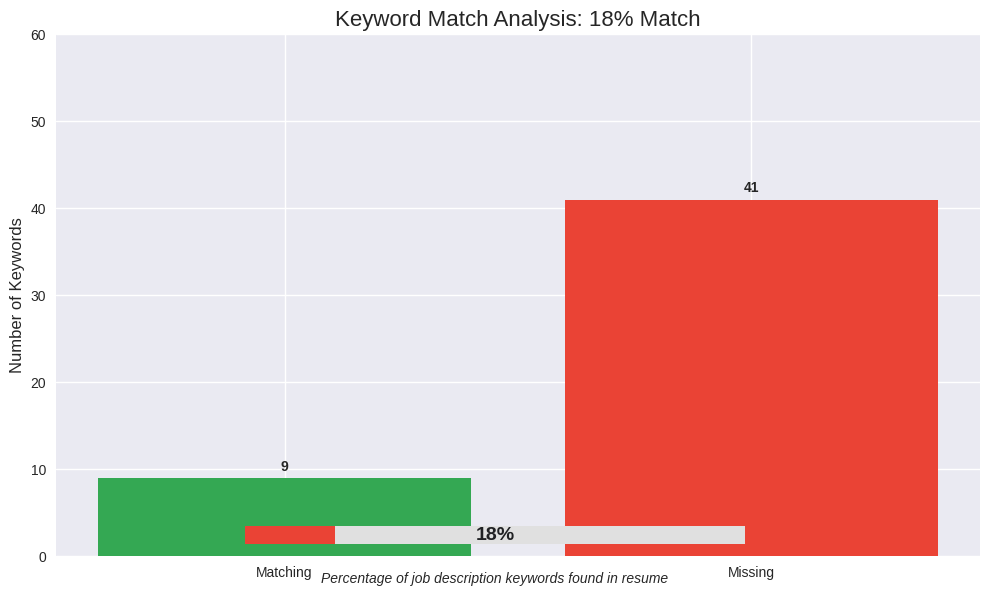

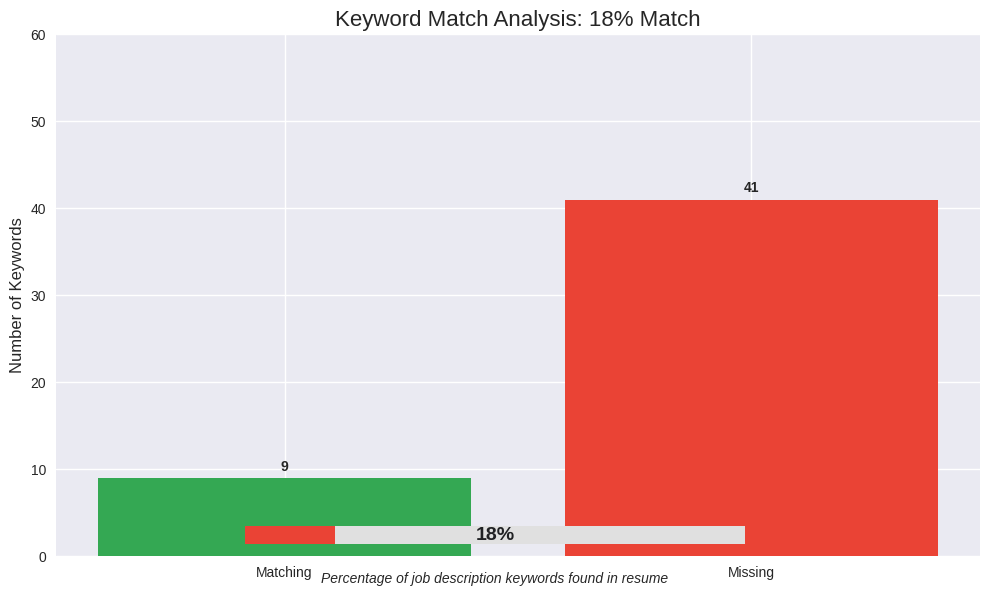

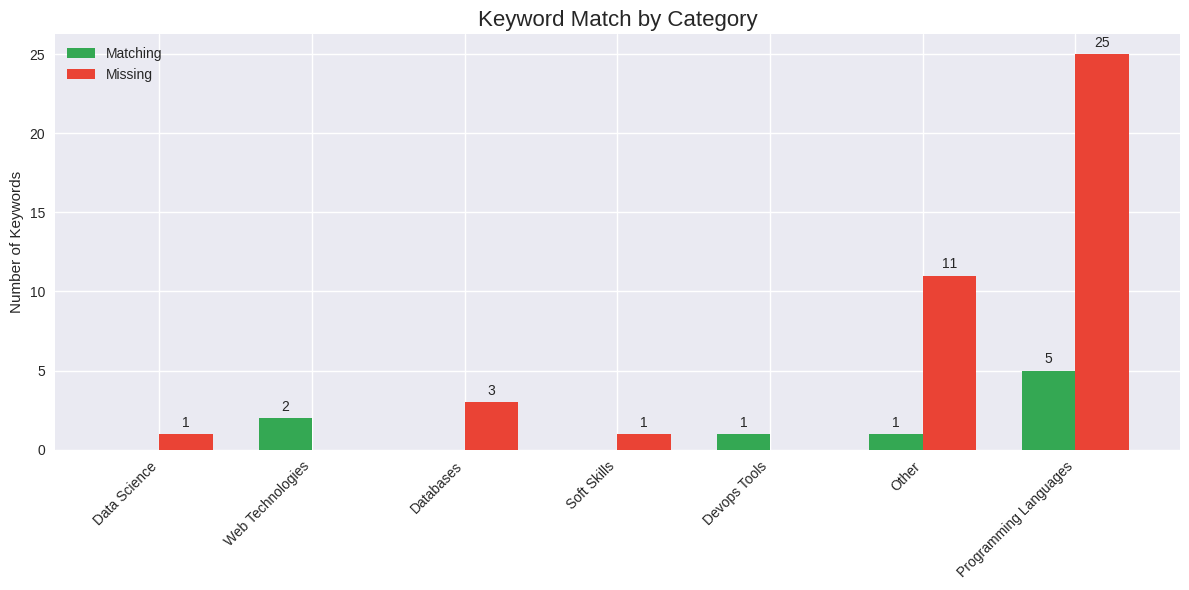

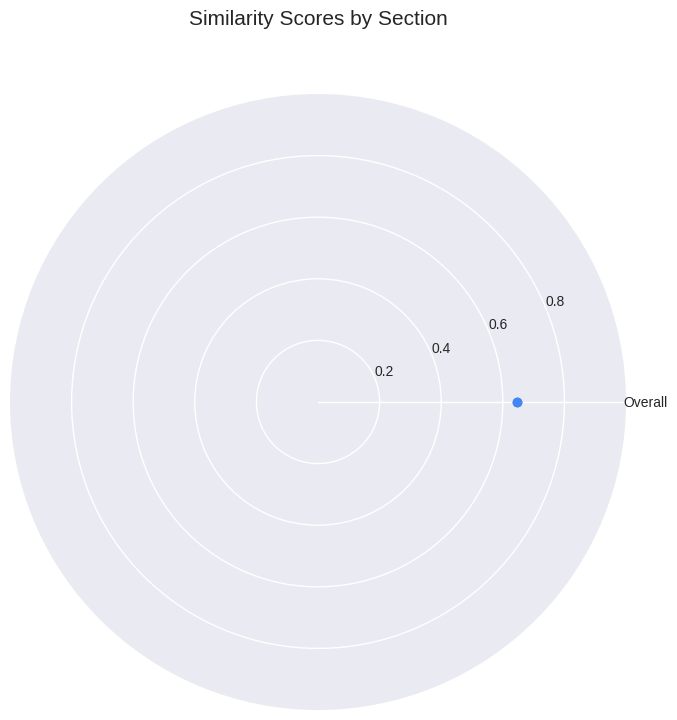

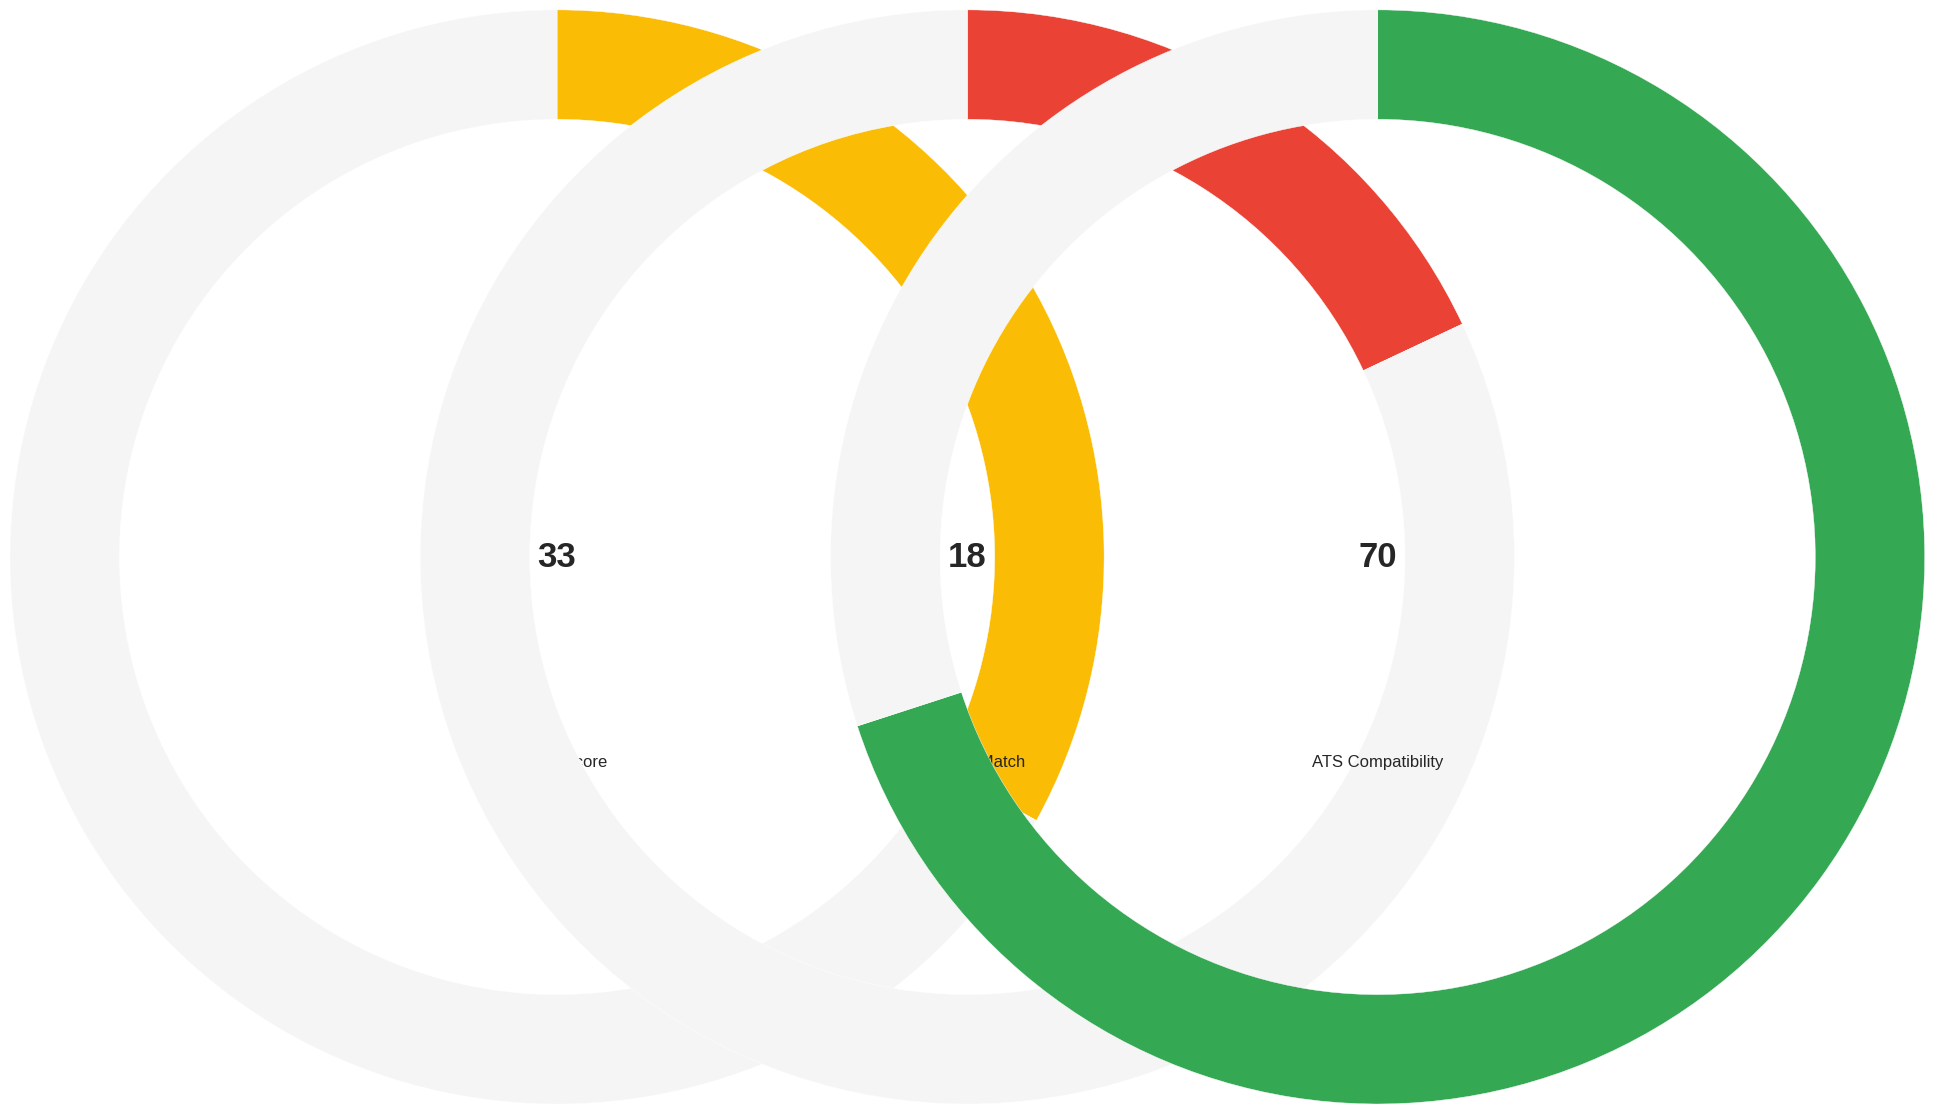

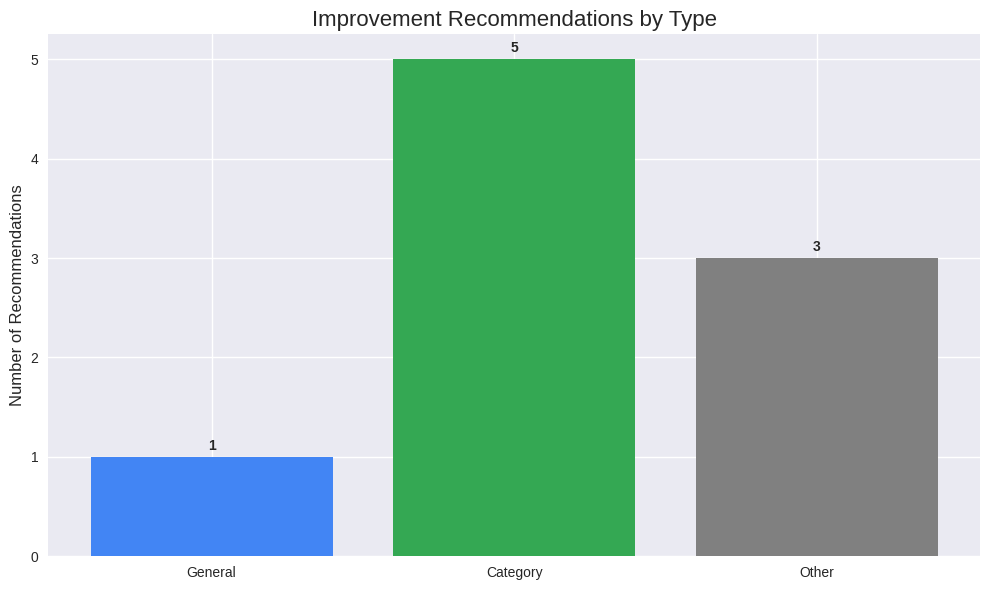

In [ ]:
import nltk
from textblob import download_corpora

# Check and download NLTK packages if missing
nltk_packages = ['punkt', 'brown', 'wordnet', 'averaged_perceptron_tagger', 'stopwords']
for package in nltk_packages:
    try:
        nltk.data.find(package)
    except LookupError:
        nltk.download(package)

# Download TextBlob corpora
download_corpora.download_all()
# Sample resume text for demonstration
sample_resume = """
JANE SMITH
Software Engineer
jane.smith@email.com | (555) 123-4567 | linkedin.com/in/janesmith | github.com/janesmith

SUMMARY
Experienced software engineer with 5+ years developing scalable web applications and cloud solutions.
Strong background in Python, JavaScript, and AWS. Passionate about creating efficient, user-friendly software.

SKILLS
Programming: Python, JavaScript, TypeScript, Java, SQL
Web Technologies: React, Node.js, Django, Flask, HTML/CSS
Cloud & DevOps: AWS (EC2, S3, Lambda), Docker, Kubernetes, CI/CD
Databases: PostgreSQL, MongoDB, Redis
Tools: Git, JIRA, Agile methodologies

EXPERIENCE
Senior Software Engineer | TechCorp Inc. | 2020 - Present
- Developed and maintained microservices architecture using Python and Flask, improving system reliability by 30%
- Implemented CI/CD pipelines using Jenkins and Docker, reducing deployment time from hours to minutes
- Led migration of legacy systems to AWS cloud infrastructure, resulting in 40% cost savings
- Mentored junior developers and conducted code reviews for team of 8 engineers

Software Engineer | WebSolutions LLC | 2018 - 2020
- Built RESTful APIs using Node.js and Express, serving 1M+ daily users
- Developed responsive front-end interfaces with React and Redux
- Optimized MongoDB queries, improving application performance by 25%
- Collaborated with product and design teams to implement new features

EDUCATION
Master of Science in Computer Science | Stanford University | 2018
Bachelor of Science in Computer Engineering | University of California, Berkeley | 2016

PROJECTS
Personal Finance Dashboard (github.com/janesmith/finance-dash)
- Full-stack application built with Python, Flask, and React
- Features include expense tracking, budget planning, and data visualization
- Implemented JWT authentication and role-based access control

Open Source Contribution: React Component Library
- Contributed to popular open-source UI component library with 5K+ stars on GitHub
- Implemented accessibility improvements and created comprehensive documentation
"""

# Sample job description for demonstration
sample_job_description = """
Senior Full Stack Engineer

About Us:
We're a fast-growing tech startup revolutionizing the healthcare industry through innovative digital solutions. Our platform connects patients with healthcare providers and makes managing health information easier than ever.

Job Description:
We're looking for a Senior Full Stack Engineer to join our engineering team. You'll work on challenging problems, build new features, and help scale our platform to support our growing user base.

Responsibilities:
- Design, develop, and maintain web applications and services
- Build responsive and intuitive user interfaces using modern JavaScript frameworks
- Create and maintain RESTful APIs and microservices
- Work with database systems to optimize performance and ensure data integrity
- Collaborate with product managers, designers, and other engineers
- Participate in code reviews and mentor junior developers
- Help establish best practices and coding standards

Requirements:
- 5+ years of experience in software development
- Strong proficiency in Python and JavaScript/TypeScript
- Experience with React, Node.js, and modern front-end frameworks
- Knowledge of web development, including HTML/CSS, HTTP protocols, and REST principles
- Experience with SQL and NoSQL databases (PostgreSQL, MongoDB)
- Familiarity with cloud platforms (AWS, Azure, or GCP)
- Experience with containerization technologies (Docker, Kubernetes)
- Understanding of CI/CD pipelines and DevOps practices
- Strong problem-solving skills and attention to detail
- Excellent communication and teamwork abilities

Preferred Qualifications:
- Experience with Django or Flask frameworks
- Familiarity with GraphQL
- Knowledge of Redis or other caching solutions
- Experience with real-time communication protocols (WebSockets)
- Contributions to open-source projects
- Understanding of healthcare industry or related fields

Benefits:
- Competitive salary and equity package
- Comprehensive health, dental, and vision insurance
- 401(k) matching
- Flexible work arrangements
- Professional development opportunities
- Paid time off and parental leave

We are an equal opportunity employer and value diversity. All employment is decided on the basis of qualifications, merit, and business need.
"""

# Run the complete analysis
print("Running complete analysis pipeline...")

results = matcher.compare({'processed_text': sample_resume, 'raw_text': sample_resume}, {'processed_text': sample_job_description, 'raw_text': sample_job_description})

# Display key results
ats_results = results['ats_results']
keyword_comparison = results['keyword_comparison']
similarity_scores = results['similarity_scores']

print("\n===== ANALYSIS RESULTS =====")
print(f"Overall ATS Optimization Score: {ats_results['overall_score']}%")
print(f"Keyword Match Score: {int(keyword_comparison['match_score'] * 100)}%")
print(f"Total Job Keywords: {keyword_comparison['total_job_keywords']}")
print(f"Matching Keywords: {keyword_comparison['total_matching']}")
print(f"Missing Keywords: {keyword_comparison['total_missing']}")
print(f"Optimization Level: {ats_results['optimization_level'].upper()}")
print(f"Total Recommendations: {ats_results['total_recommendations']}")

# Display similarity scores
print("\n===== SIMILARITY SCORES =====")
for section, score in similarity_scores.items():
    print(f"{section.replace('_', ' ').title()}: {score:.2f}")

# Display top matching keywords
print("\n===== TOP MATCHING KEYWORDS =====")
for keyword in keyword_comparison['matching_keywords'][:10]:
    print(f"✓ {keyword}")

# Display top missing keywords
print("\n===== TOP MISSING KEYWORDS =====")
for keyword in keyword_comparison['missing_keywords'][:10]:
    print(f"✗ {keyword}")

# Display top recommendations
print("\n===== TOP RECOMMENDATIONS =====")
for rec in ats_results['recommendations'][:5]:
    print(f"• {rec['title']}")
    print(f"  {rec['action']}")

# Show the keyword match chart
plt.figure(figsize=(10, 6))
keyword_chart = results['charts']['keyword_chart']
plt.close()
display(keyword_chart)

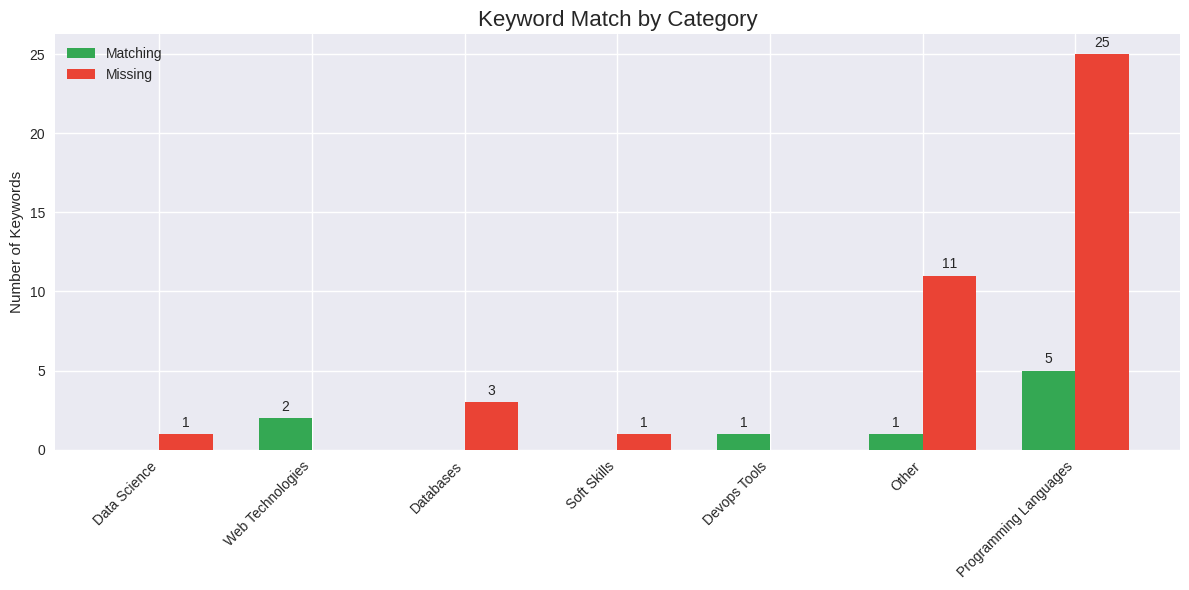

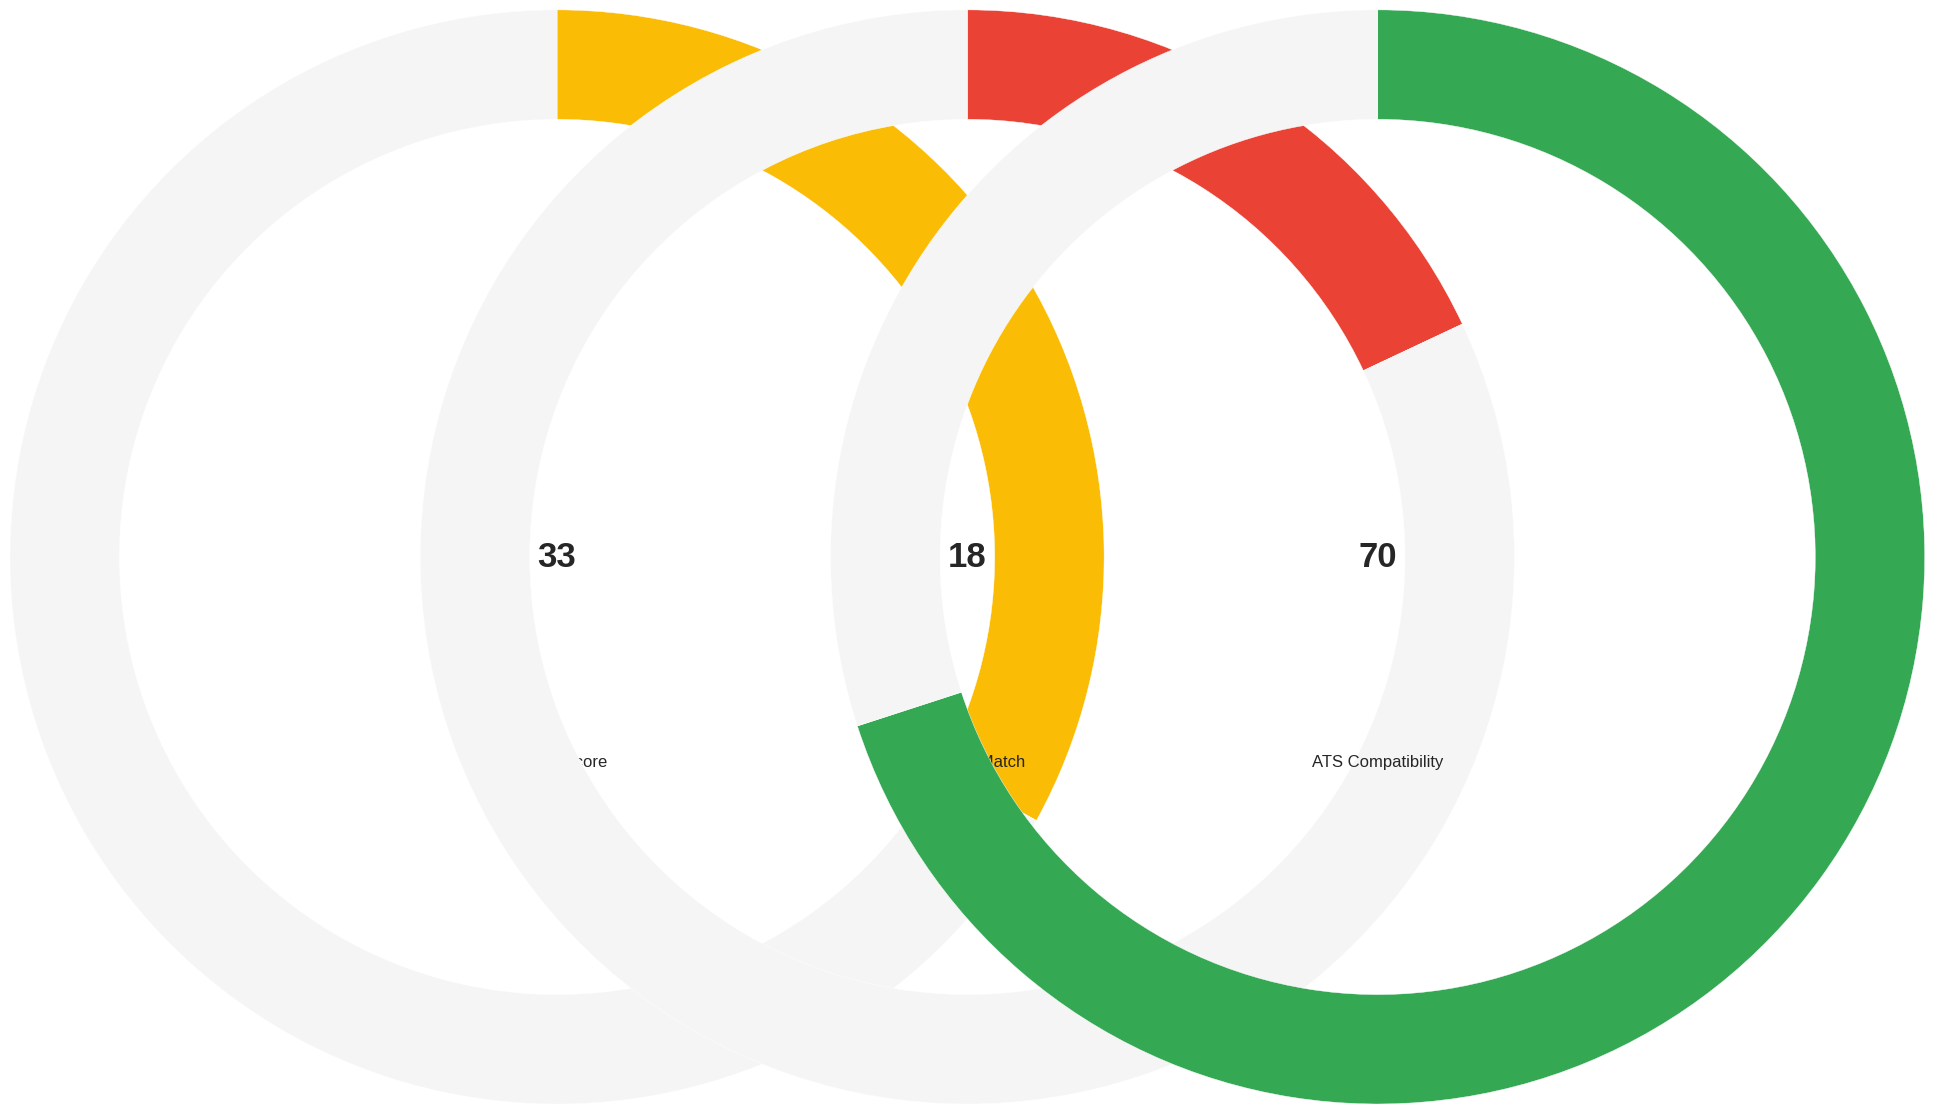

In [ ]:
# Show the category match chart
plt.figure(figsize=(12, 6))
category_chart = results['charts']['category_chart']
plt.close()
display(category_chart)

# Show the ATS score gauge
plt.figure(figsize=(15, 5))
score_gauge = results['charts']['score_gauge']
plt.close()
display(score_gauge)

#10. Conclusion & Best Practices
In this notebook, we've built a comprehensive ATS-optimized resume builder system that:

Parses resumes and job descriptions to extract structured information
Extracts and compares keywords using NLP techniques
Calculates similarity scores to determine resume-job compatibility
Analyzes ATS compatibility and provides optimization recommendations
Visualizes results through informative charts and reports
##Best Practices for ATS-Optimized Resumes:
**Use the right file format**: Submit your resume as a text-based PDF or DOCX file to ensure compatibility with most ATS systems.

**Keep formatting simple:** Use standard section headings, avoid tables, columns, headers/footers, and complex formatting.

**Include relevant keywords:** Incorporate important skills and terms from the job description naturally throughout your resume.

**Use standard section headers:** Include clear sections for Summary, Experience, Skills, and Education that ATS systems can easily identify.

**Avoid images and graphics:** Don't include photos, logos, or charts that ATS systems can't parse.
**Use standard bullet points:** Stick to standard bullets (•, -, *) rather than custom symbols.

**Include contact information in the main body:** Don't put your contact information in headers or footers where ATS might miss it.

**Spell out abbreviations:** Include both the spelled-out version and acronym of important terms (e.g., "Application Tracking System (ATS)").

**Tailor for each application:** Customize your resume for each job application based on the specific job description.

**Balance optimization with readability:** Ensure your resume is optimized for ATS but still reads naturally for human recruiters.
##Future Enhancements:
Implement more sophisticated resume section detection using machine learning models
Add support for more file formats and improved PDF parsing
Develop an interactive web interface for easier use
Incorporate industry-specific keyword databases for better recommendations
Add resume rewriting suggestions using NLP techniques
Implement automated resume generation based on job descriptions
By following these best practices and using tools like ResumeMatcher, you can significantly increase your chances of getting past the ATS screening stage and landing interviews for your desired positions.